In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "int97"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 176
Categorical features: 7
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 248
Categorical Columns: 7


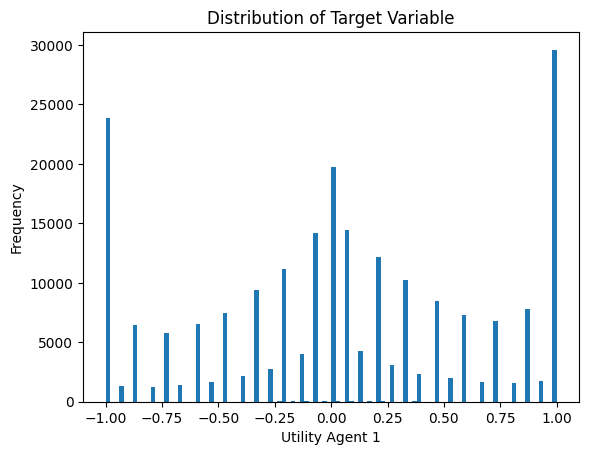

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6118270	test: 0.5484782	best: 0.5484782 (0)	total: 155ms	remaining: 7m 44s


50:	learn: 0.3823979	test: 0.4639554	best: 0.4639554 (50)	total: 4.27s	remaining: 4m 6s


100:	learn: 0.3435614	test: 0.4456984	best: 0.4456984 (100)	total: 8.55s	remaining: 4m 5s


150:	learn: 0.3202015	test: 0.4378013	best: 0.4378013 (150)	total: 12.7s	remaining: 4m


200:	learn: 0.3039145	test: 0.4337213	best: 0.4337103 (198)	total: 16.9s	remaining: 3m 54s


250:	learn: 0.2925168	test: 0.4308263	best: 0.4308263 (250)	total: 21.2s	remaining: 3m 51s


300:	learn: 0.2832430	test: 0.4291686	best: 0.4291214 (296)	total: 25.4s	remaining: 3m 48s


350:	learn: 0.2750720	test: 0.4280660	best: 0.4280660 (350)	total: 29.7s	remaining: 3m 44s


400:	learn: 0.2688346	test: 0.4266611	best: 0.4266611 (400)	total: 34.1s	remaining: 3m 40s


450:	learn: 0.2627175	test: 0.4259989	best: 0.4259989 (450)	total: 38.4s	remaining: 3m 37s


500:	learn: 0.2573204	test: 0.4256036	best: 0.4255782 (499)	total: 42.8s	remaining: 3m 33s


550:	learn: 0.2527924	test: 0.4250412	best: 0.4250303 (548)	total: 47.1s	remaining: 3m 29s


600:	learn: 0.2486600	test: 0.4245580	best: 0.4245563 (599)	total: 51.5s	remaining: 3m 25s


650:	learn: 0.2443143	test: 0.4241579	best: 0.4241579 (650)	total: 55.7s	remaining: 3m 21s


700:	learn: 0.2405566	test: 0.4237989	best: 0.4236813 (686)	total: 1m	remaining: 3m 16s


750:	learn: 0.2370378	test: 0.4234918	best: 0.4234635 (740)	total: 1m 4s	remaining: 3m 12s


800:	learn: 0.2338505	test: 0.4232351	best: 0.4232351 (800)	total: 1m 8s	remaining: 3m 8s


850:	learn: 0.2307298	test: 0.4227601	best: 0.4227601 (850)	total: 1m 13s	remaining: 3m 4s


900:	learn: 0.2279753	test: 0.4226374	best: 0.4225901 (882)	total: 1m 17s	remaining: 3m


950:	learn: 0.2252753	test: 0.4225191	best: 0.4225102 (949)	total: 1m 21s	remaining: 2m 55s


1000:	learn: 0.2226681	test: 0.4223133	best: 0.4222660 (990)	total: 1m 26s	remaining: 2m 51s


1050:	learn: 0.2202568	test: 0.4222192	best: 0.4221890 (1048)	total: 1m 30s	remaining: 2m 47s


1100:	learn: 0.2179974	test: 0.4221993	best: 0.4221890 (1048)	total: 1m 34s	remaining: 2m 43s


1150:	learn: 0.2157937	test: 0.4220729	best: 0.4220729 (1150)	total: 1m 39s	remaining: 2m 39s


1200:	learn: 0.2136514	test: 0.4218991	best: 0.4218991 (1200)	total: 1m 43s	remaining: 2m 34s


1250:	learn: 0.2116131	test: 0.4219211	best: 0.4218947 (1203)	total: 1m 47s	remaining: 2m 30s


1300:	learn: 0.2095815	test: 0.4218300	best: 0.4218217 (1292)	total: 1m 52s	remaining: 2m 26s


1350:	learn: 0.2076250	test: 0.4219112	best: 0.4218217 (1292)	total: 1m 56s	remaining: 2m 22s


1400:	learn: 0.2057848	test: 0.4218518	best: 0.4218211 (1387)	total: 2m	remaining: 2m 17s


1450:	learn: 0.2038021	test: 0.4217931	best: 0.4217672 (1441)	total: 2m 5s	remaining: 2m 13s


1500:	learn: 0.2018266	test: 0.4217766	best: 0.4217195 (1470)	total: 2m 9s	remaining: 2m 9s


1550:	learn: 0.2001545	test: 0.4217563	best: 0.4216857 (1509)	total: 2m 13s	remaining: 2m 5s


1600:	learn: 0.1984889	test: 0.4215920	best: 0.4215920 (1600)	total: 2m 18s	remaining: 2m


1650:	learn: 0.1967348	test: 0.4215826	best: 0.4215261 (1619)	total: 2m 22s	remaining: 1m 56s


1700:	learn: 0.1950519	test: 0.4215829	best: 0.4215261 (1619)	total: 2m 26s	remaining: 1m 52s


1750:	learn: 0.1935743	test: 0.4215749	best: 0.4215261 (1619)	total: 2m 31s	remaining: 1m 47s


1800:	learn: 0.1919732	test: 0.4214786	best: 0.4214711 (1799)	total: 2m 35s	remaining: 1m 43s


1850:	learn: 0.1903237	test: 0.4214365	best: 0.4214281 (1836)	total: 2m 39s	remaining: 1m 39s


1900:	learn: 0.1887298	test: 0.4215238	best: 0.4214281 (1836)	total: 2m 44s	remaining: 1m 34s


1950:	learn: 0.1871993	test: 0.4213285	best: 0.4213274 (1948)	total: 2m 48s	remaining: 1m 30s


2000:	learn: 0.1857332	test: 0.4212923	best: 0.4212566 (1993)	total: 2m 52s	remaining: 1m 26s


2050:	learn: 0.1844684	test: 0.4212870	best: 0.4212566 (1993)	total: 2m 57s	remaining: 1m 21s


2100:	learn: 0.1831482	test: 0.4212808	best: 0.4212566 (1993)	total: 3m 1s	remaining: 1m 17s


2150:	learn: 0.1818816	test: 0.4213579	best: 0.4212566 (1993)	total: 3m 5s	remaining: 1m 13s


2200:	learn: 0.1804302	test: 0.4213551	best: 0.4212566 (1993)	total: 3m 10s	remaining: 1m 9s


2250:	learn: 0.1790964	test: 0.4213297	best: 0.4212566 (1993)	total: 3m 14s	remaining: 1m 4s


2300:	learn: 0.1778439	test: 0.4213008	best: 0.4212516 (2287)	total: 3m 19s	remaining: 1m


2350:	learn: 0.1765834	test: 0.4213271	best: 0.4212516 (2287)	total: 3m 23s	remaining: 56.2s


2400:	learn: 0.1753612	test: 0.4213860	best: 0.4212516 (2287)	total: 3m 27s	remaining: 51.8s


2450:	learn: 0.1740710	test: 0.4213513	best: 0.4212516 (2287)	total: 3m 32s	remaining: 47.5s


2500:	learn: 0.1728169	test: 0.4213377	best: 0.4212516 (2287)	total: 3m 36s	remaining: 43.2s


2550:	learn: 0.1715127	test: 0.4213092	best: 0.4212516 (2287)	total: 3m 40s	remaining: 38.9s


2600:	learn: 0.1703896	test: 0.4213758	best: 0.4212516 (2287)	total: 3m 45s	remaining: 34.5s


2650:	learn: 0.1693707	test: 0.4213980	best: 0.4212516 (2287)	total: 3m 49s	remaining: 30.2s


2700:	learn: 0.1682599	test: 0.4214261	best: 0.4212516 (2287)	total: 3m 53s	remaining: 25.9s


2750:	learn: 0.1671027	test: 0.4214039	best: 0.4212516 (2287)	total: 3m 58s	remaining: 21.5s


2800:	learn: 0.1659547	test: 0.4214258	best: 0.4212516 (2287)	total: 4m 2s	remaining: 17.2s


2850:	learn: 0.1650340	test: 0.4214313	best: 0.4212516 (2287)	total: 4m 6s	remaining: 12.9s


2900:	learn: 0.1639786	test: 0.4213558	best: 0.4212516 (2287)	total: 4m 11s	remaining: 8.57s


2950:	learn: 0.1629099	test: 0.4213716	best: 0.4212516 (2287)	total: 4m 15s	remaining: 4.24s


2999:	learn: 0.1619249	test: 0.4213274	best: 0.4212516 (2287)	total: 4m 19s	remaining: 0us

bestTest = 0.4212516048
bestIteration = 2287

Shrink model to first 2288 iterations.


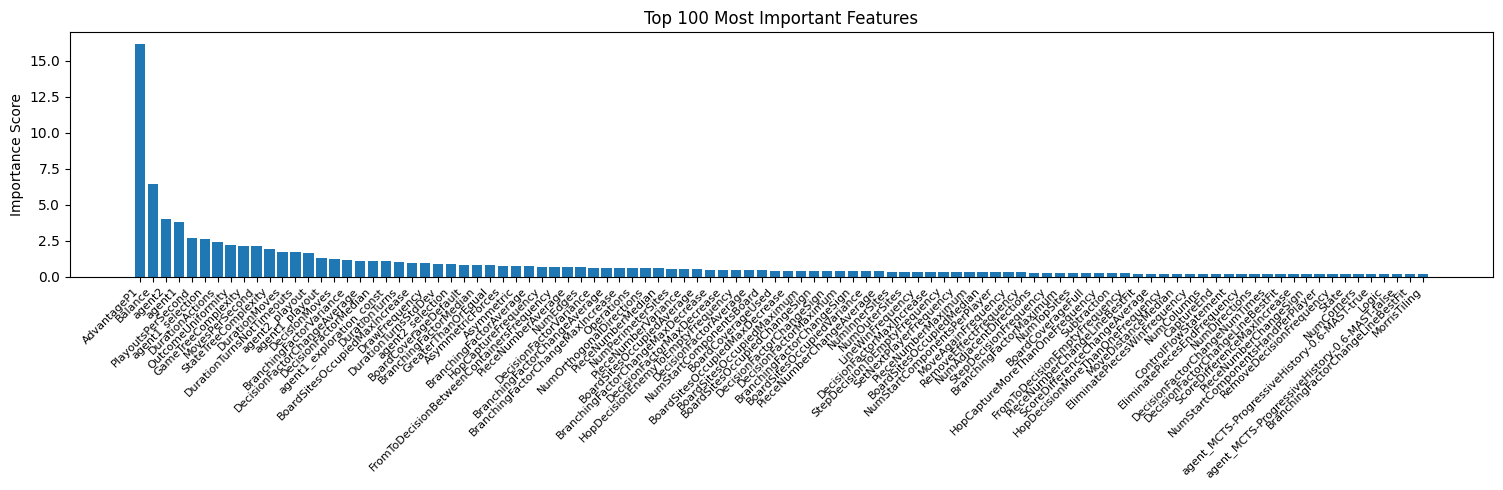

Fold 1 - RMSE: 0.42090325598542655
Fold 2


0:	learn: 0.6066625	test: 0.5784464	best: 0.5784464 (0)	total: 80.2ms	remaining: 4m


50:	learn: 0.3881854	test: 0.4753916	best: 0.4753916 (50)	total: 4.24s	remaining: 4m 5s


100:	learn: 0.3489796	test: 0.4584997	best: 0.4584836 (99)	total: 8.69s	remaining: 4m 9s


150:	learn: 0.3273200	test: 0.4535594	best: 0.4535594 (150)	total: 13.1s	remaining: 4m 6s


200:	learn: 0.3119486	test: 0.4511370	best: 0.4511167 (198)	total: 17.5s	remaining: 4m 3s


250:	learn: 0.2994084	test: 0.4496278	best: 0.4495044 (248)	total: 21.9s	remaining: 3m 59s


300:	learn: 0.2902059	test: 0.4479377	best: 0.4479377 (300)	total: 26.3s	remaining: 3m 56s


350:	learn: 0.2832051	test: 0.4464965	best: 0.4464965 (350)	total: 30.9s	remaining: 3m 52s


400:	learn: 0.2762319	test: 0.4460962	best: 0.4460843 (399)	total: 35.3s	remaining: 3m 48s


450:	learn: 0.2702289	test: 0.4452503	best: 0.4452413 (449)	total: 39.6s	remaining: 3m 43s


500:	learn: 0.2652352	test: 0.4443901	best: 0.4443901 (500)	total: 44.1s	remaining: 3m 39s


550:	learn: 0.2603740	test: 0.4440703	best: 0.4440283 (544)	total: 48.5s	remaining: 3m 35s


600:	learn: 0.2558898	test: 0.4436166	best: 0.4435155 (593)	total: 53s	remaining: 3m 31s


650:	learn: 0.2517242	test: 0.4430876	best: 0.4430777 (649)	total: 57.4s	remaining: 3m 27s


700:	learn: 0.2479755	test: 0.4427325	best: 0.4427325 (700)	total: 1m 1s	remaining: 3m 22s


750:	learn: 0.2446926	test: 0.4424192	best: 0.4424178 (749)	total: 1m 6s	remaining: 3m 18s


800:	learn: 0.2411958	test: 0.4419466	best: 0.4419143 (797)	total: 1m 10s	remaining: 3m 14s


850:	learn: 0.2379330	test: 0.4414679	best: 0.4414413 (849)	total: 1m 15s	remaining: 3m 10s


900:	learn: 0.2350620	test: 0.4413600	best: 0.4413265 (897)	total: 1m 19s	remaining: 3m 6s


950:	learn: 0.2322054	test: 0.4411266	best: 0.4411266 (950)	total: 1m 24s	remaining: 3m 1s


1000:	learn: 0.2296868	test: 0.4410863	best: 0.4410730 (998)	total: 1m 28s	remaining: 2m 57s


1050:	learn: 0.2269320	test: 0.4408025	best: 0.4407977 (1048)	total: 1m 33s	remaining: 2m 53s


1100:	learn: 0.2245504	test: 0.4407257	best: 0.4406876 (1064)	total: 1m 37s	remaining: 2m 48s


1150:	learn: 0.2221161	test: 0.4405299	best: 0.4405299 (1150)	total: 1m 42s	remaining: 2m 44s


1200:	learn: 0.2198907	test: 0.4404248	best: 0.4403544 (1192)	total: 1m 46s	remaining: 2m 40s


1250:	learn: 0.2177924	test: 0.4403189	best: 0.4403189 (1250)	total: 1m 51s	remaining: 2m 35s


1300:	learn: 0.2157274	test: 0.4402330	best: 0.4402006 (1263)	total: 1m 55s	remaining: 2m 31s


1350:	learn: 0.2138535	test: 0.4402491	best: 0.4401794 (1319)	total: 2m	remaining: 2m 27s


1400:	learn: 0.2119343	test: 0.4401889	best: 0.4401794 (1319)	total: 2m 5s	remaining: 2m 22s


1450:	learn: 0.2100297	test: 0.4401553	best: 0.4401450 (1439)	total: 2m 9s	remaining: 2m 18s


1500:	learn: 0.2083992	test: 0.4400510	best: 0.4400277 (1495)	total: 2m 14s	remaining: 2m 14s


1550:	learn: 0.2067386	test: 0.4399728	best: 0.4399529 (1548)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2052218	test: 0.4398208	best: 0.4398141 (1599)	total: 2m 23s	remaining: 2m 5s


1650:	learn: 0.2034123	test: 0.4396601	best: 0.4396089 (1642)	total: 2m 27s	remaining: 2m


1700:	learn: 0.2018645	test: 0.4395938	best: 0.4395938 (1700)	total: 2m 32s	remaining: 1m 56s


1750:	learn: 0.2001778	test: 0.4395669	best: 0.4395669 (1750)	total: 2m 37s	remaining: 1m 52s


1800:	learn: 0.1986802	test: 0.4395271	best: 0.4394861 (1768)	total: 2m 41s	remaining: 1m 47s


1850:	learn: 0.1972131	test: 0.4394566	best: 0.4394566 (1850)	total: 2m 46s	remaining: 1m 43s


1900:	learn: 0.1956971	test: 0.4395339	best: 0.4394450 (1863)	total: 2m 51s	remaining: 1m 38s


1950:	learn: 0.1941402	test: 0.4394738	best: 0.4394450 (1863)	total: 2m 55s	remaining: 1m 34s


2000:	learn: 0.1926001	test: 0.4394548	best: 0.4394450 (1863)	total: 3m	remaining: 1m 29s


2050:	learn: 0.1911983	test: 0.4393040	best: 0.4393040 (2050)	total: 3m 4s	remaining: 1m 25s


2100:	learn: 0.1897691	test: 0.4392760	best: 0.4392696 (2064)	total: 3m 9s	remaining: 1m 21s


2150:	learn: 0.1883738	test: 0.4392436	best: 0.4392436 (2150)	total: 3m 13s	remaining: 1m 16s


2200:	learn: 0.1870357	test: 0.4392551	best: 0.4392232 (2177)	total: 3m 18s	remaining: 1m 12s


2250:	learn: 0.1856766	test: 0.4391988	best: 0.4391627 (2243)	total: 3m 23s	remaining: 1m 7s


2300:	learn: 0.1844057	test: 0.4391465	best: 0.4391417 (2299)	total: 3m 27s	remaining: 1m 3s


2350:	learn: 0.1831908	test: 0.4391064	best: 0.4391064 (2350)	total: 3m 32s	remaining: 58.7s


2400:	learn: 0.1819300	test: 0.4390400	best: 0.4390302 (2396)	total: 3m 37s	remaining: 54.2s


2450:	learn: 0.1807519	test: 0.4390866	best: 0.4390302 (2396)	total: 3m 41s	remaining: 49.7s


2500:	learn: 0.1794808	test: 0.4390233	best: 0.4390163 (2497)	total: 3m 46s	remaining: 45.2s


2550:	learn: 0.1783044	test: 0.4389663	best: 0.4389500 (2527)	total: 3m 50s	remaining: 40.6s


2600:	learn: 0.1771858	test: 0.4389947	best: 0.4389500 (2527)	total: 3m 55s	remaining: 36.1s


2650:	learn: 0.1760761	test: 0.4389509	best: 0.4389362 (2646)	total: 4m	remaining: 31.6s


2700:	learn: 0.1750128	test: 0.4389264	best: 0.4389114 (2679)	total: 4m 4s	remaining: 27.1s


2750:	learn: 0.1738826	test: 0.4389287	best: 0.4389068 (2705)	total: 4m 9s	remaining: 22.6s


2800:	learn: 0.1727560	test: 0.4388935	best: 0.4388901 (2759)	total: 4m 14s	remaining: 18.1s


2850:	learn: 0.1717257	test: 0.4388035	best: 0.4387949 (2849)	total: 4m 18s	remaining: 13.5s


2900:	learn: 0.1706129	test: 0.4387970	best: 0.4387876 (2872)	total: 4m 23s	remaining: 8.98s


2950:	learn: 0.1695439	test: 0.4387838	best: 0.4387696 (2932)	total: 4m 27s	remaining: 4.45s


2999:	learn: 0.1685558	test: 0.4387576	best: 0.4387534 (2996)	total: 4m 32s	remaining: 0us

bestTest = 0.4387533941
bestIteration = 2996

Shrink model to first 2997 iterations.


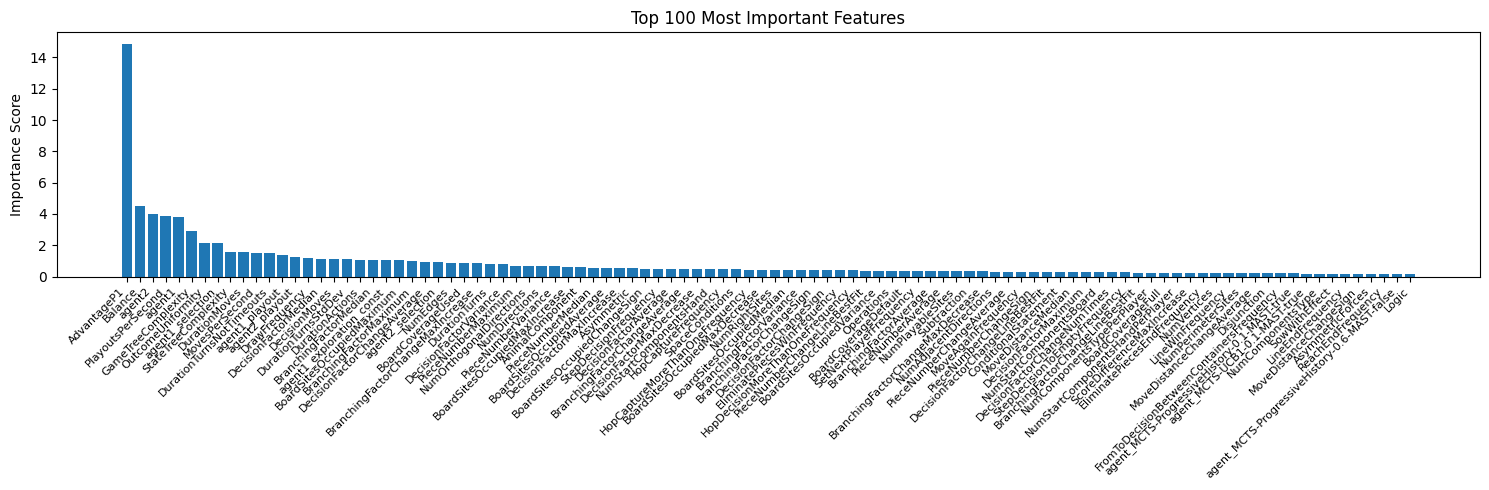

Fold 2 - RMSE: 0.43817295457324834
Fold 3


0:	learn: 0.6015208	test: 0.5985633	best: 0.5985633 (0)	total: 79.7ms	remaining: 3m 58s


50:	learn: 0.3870621	test: 0.4693012	best: 0.4693012 (50)	total: 4.27s	remaining: 4m 6s


100:	learn: 0.3494342	test: 0.4550648	best: 0.4550648 (100)	total: 8.75s	remaining: 4m 11s


150:	learn: 0.3283115	test: 0.4486862	best: 0.4486862 (150)	total: 13.2s	remaining: 4m 8s


200:	learn: 0.3122946	test: 0.4457148	best: 0.4456288 (195)	total: 17.6s	remaining: 4m 5s


250:	learn: 0.3005416	test: 0.4421675	best: 0.4421675 (250)	total: 22s	remaining: 4m 1s


300:	learn: 0.2914560	test: 0.4406852	best: 0.4406852 (300)	total: 26.6s	remaining: 3m 58s


350:	learn: 0.2834780	test: 0.4398164	best: 0.4396536 (340)	total: 31.1s	remaining: 3m 54s


400:	learn: 0.2767189	test: 0.4382785	best: 0.4382785 (400)	total: 35.6s	remaining: 3m 50s


450:	learn: 0.2707483	test: 0.4376901	best: 0.4376414 (447)	total: 40.1s	remaining: 3m 46s


500:	learn: 0.2653237	test: 0.4367342	best: 0.4367342 (500)	total: 44.6s	remaining: 3m 42s


550:	learn: 0.2600369	test: 0.4363791	best: 0.4363448 (538)	total: 49.1s	remaining: 3m 38s


600:	learn: 0.2554573	test: 0.4357094	best: 0.4357094 (600)	total: 53.6s	remaining: 3m 33s


650:	learn: 0.2513666	test: 0.4352964	best: 0.4352657 (649)	total: 58s	remaining: 3m 29s


700:	learn: 0.2472940	test: 0.4351163	best: 0.4350743 (681)	total: 1m 2s	remaining: 3m 24s


750:	learn: 0.2435663	test: 0.4347206	best: 0.4347138 (749)	total: 1m 6s	remaining: 3m 20s


800:	learn: 0.2402547	test: 0.4346044	best: 0.4345547 (783)	total: 1m 11s	remaining: 3m 15s


850:	learn: 0.2370120	test: 0.4343454	best: 0.4343454 (850)	total: 1m 15s	remaining: 3m 11s


900:	learn: 0.2339702	test: 0.4340461	best: 0.4340461 (900)	total: 1m 20s	remaining: 3m 7s


950:	learn: 0.2311340	test: 0.4339008	best: 0.4338917 (934)	total: 1m 24s	remaining: 3m 2s


1000:	learn: 0.2283929	test: 0.4337145	best: 0.4337145 (1000)	total: 1m 29s	remaining: 2m 58s


1050:	learn: 0.2257684	test: 0.4335302	best: 0.4335302 (1050)	total: 1m 33s	remaining: 2m 53s


1100:	learn: 0.2235700	test: 0.4333179	best: 0.4333179 (1100)	total: 1m 38s	remaining: 2m 49s


1150:	learn: 0.2213491	test: 0.4332051	best: 0.4331490 (1126)	total: 1m 42s	remaining: 2m 45s


1200:	learn: 0.2191099	test: 0.4330255	best: 0.4330255 (1200)	total: 1m 47s	remaining: 2m 40s


1250:	learn: 0.2167978	test: 0.4329424	best: 0.4329251 (1244)	total: 1m 51s	remaining: 2m 36s


1300:	learn: 0.2147693	test: 0.4329505	best: 0.4329047 (1271)	total: 1m 56s	remaining: 2m 31s


1350:	learn: 0.2127005	test: 0.4328763	best: 0.4328763 (1350)	total: 2m	remaining: 2m 27s


1400:	learn: 0.2108168	test: 0.4328007	best: 0.4327740 (1386)	total: 2m 5s	remaining: 2m 22s


1450:	learn: 0.2090917	test: 0.4326634	best: 0.4325971 (1445)	total: 2m 9s	remaining: 2m 18s


1500:	learn: 0.2074008	test: 0.4325734	best: 0.4325433 (1479)	total: 2m 14s	remaining: 2m 14s


1550:	learn: 0.2056110	test: 0.4325456	best: 0.4325131 (1532)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2039505	test: 0.4324383	best: 0.4324242 (1599)	total: 2m 23s	remaining: 2m 5s


1650:	learn: 0.2023044	test: 0.4323702	best: 0.4323662 (1648)	total: 2m 27s	remaining: 2m


1700:	learn: 0.2005346	test: 0.4322621	best: 0.4322554 (1698)	total: 2m 32s	remaining: 1m 56s


1750:	learn: 0.1988667	test: 0.4322863	best: 0.4322460 (1710)	total: 2m 36s	remaining: 1m 51s


1800:	learn: 0.1971705	test: 0.4322255	best: 0.4322124 (1796)	total: 2m 41s	remaining: 1m 47s


1850:	learn: 0.1957085	test: 0.4321043	best: 0.4321043 (1850)	total: 2m 45s	remaining: 1m 42s


1900:	learn: 0.1943172	test: 0.4320951	best: 0.4320906 (1896)	total: 2m 50s	remaining: 1m 38s


1950:	learn: 0.1927903	test: 0.4320100	best: 0.4320087 (1949)	total: 2m 54s	remaining: 1m 34s


2000:	learn: 0.1913184	test: 0.4319471	best: 0.4319237 (1987)	total: 2m 59s	remaining: 1m 29s


2050:	learn: 0.1898801	test: 0.4319159	best: 0.4319029 (2012)	total: 3m 3s	remaining: 1m 25s


2100:	learn: 0.1884362	test: 0.4318154	best: 0.4318112 (2098)	total: 3m 8s	remaining: 1m 20s


2150:	learn: 0.1871544	test: 0.4318081	best: 0.4317848 (2129)	total: 3m 12s	remaining: 1m 16s


2200:	learn: 0.1858013	test: 0.4318242	best: 0.4317848 (2129)	total: 3m 17s	remaining: 1m 11s


2250:	learn: 0.1844542	test: 0.4319011	best: 0.4317848 (2129)	total: 3m 21s	remaining: 1m 7s


2300:	learn: 0.1831423	test: 0.4318772	best: 0.4317848 (2129)	total: 3m 26s	remaining: 1m 2s


2350:	learn: 0.1818009	test: 0.4318531	best: 0.4317848 (2129)	total: 3m 30s	remaining: 58.2s


2400:	learn: 0.1804415	test: 0.4317914	best: 0.4317822 (2395)	total: 3m 35s	remaining: 53.7s


2450:	learn: 0.1790646	test: 0.4318007	best: 0.4317652 (2426)	total: 3m 39s	remaining: 49.2s


2500:	learn: 0.1776843	test: 0.4319206	best: 0.4317652 (2426)	total: 3m 44s	remaining: 44.7s


2550:	learn: 0.1764808	test: 0.4318999	best: 0.4317652 (2426)	total: 3m 48s	remaining: 40.2s


2600:	learn: 0.1752578	test: 0.4318780	best: 0.4317652 (2426)	total: 3m 52s	remaining: 35.7s


2650:	learn: 0.1740946	test: 0.4318947	best: 0.4317652 (2426)	total: 3m 57s	remaining: 31.2s


2700:	learn: 0.1729619	test: 0.4318417	best: 0.4317652 (2426)	total: 4m 1s	remaining: 26.8s


2750:	learn: 0.1718678	test: 0.4318819	best: 0.4317652 (2426)	total: 4m 6s	remaining: 22.3s


2800:	learn: 0.1708109	test: 0.4318445	best: 0.4317652 (2426)	total: 4m 10s	remaining: 17.8s


2850:	learn: 0.1696775	test: 0.4318713	best: 0.4317652 (2426)	total: 4m 15s	remaining: 13.3s


2900:	learn: 0.1686474	test: 0.4319203	best: 0.4317652 (2426)	total: 4m 19s	remaining: 8.87s


2950:	learn: 0.1675299	test: 0.4318724	best: 0.4317652 (2426)	total: 4m 24s	remaining: 4.39s


2999:	learn: 0.1664715	test: 0.4319190	best: 0.4317652 (2426)	total: 4m 28s	remaining: 0us

bestTest = 0.43176517
bestIteration = 2426

Shrink model to first 2427 iterations.


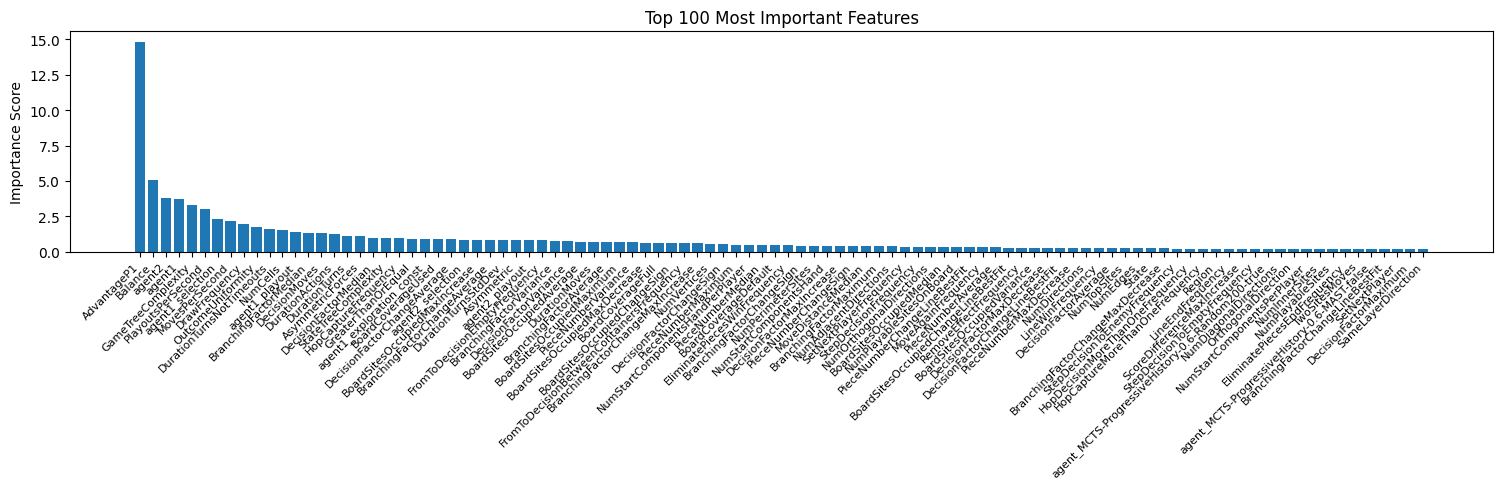

Fold 3 - RMSE: 0.43109219280577804
Fold 4


0:	learn: 0.6052211	test: 0.5896886	best: 0.5896886 (0)	total: 80.6ms	remaining: 4m 1s


50:	learn: 0.3871106	test: 0.4872844	best: 0.4872844 (50)	total: 4.3s	remaining: 4m 8s


100:	learn: 0.3461832	test: 0.4675577	best: 0.4675479 (99)	total: 8.7s	remaining: 4m 9s


150:	learn: 0.3237336	test: 0.4601122	best: 0.4601122 (150)	total: 13s	remaining: 4m 5s


200:	learn: 0.3077281	test: 0.4566326	best: 0.4566326 (200)	total: 17.4s	remaining: 4m 2s


250:	learn: 0.2958038	test: 0.4543837	best: 0.4543837 (250)	total: 21.8s	remaining: 3m 58s


300:	learn: 0.2867514	test: 0.4524803	best: 0.4524803 (300)	total: 26.1s	remaining: 3m 54s


350:	learn: 0.2788777	test: 0.4512799	best: 0.4512627 (349)	total: 30.6s	remaining: 3m 50s


400:	learn: 0.2725051	test: 0.4500900	best: 0.4500900 (400)	total: 34.9s	remaining: 3m 46s


450:	learn: 0.2661040	test: 0.4493571	best: 0.4491981 (438)	total: 39.3s	remaining: 3m 42s


500:	learn: 0.2604559	test: 0.4487537	best: 0.4486631 (496)	total: 43.8s	remaining: 3m 38s


550:	learn: 0.2555078	test: 0.4481255	best: 0.4481255 (550)	total: 48.2s	remaining: 3m 34s


600:	learn: 0.2509309	test: 0.4475300	best: 0.4475181 (591)	total: 52.6s	remaining: 3m 30s


650:	learn: 0.2470110	test: 0.4472132	best: 0.4471764 (636)	total: 57s	remaining: 3m 25s


700:	learn: 0.2431320	test: 0.4466792	best: 0.4466518 (695)	total: 1m 1s	remaining: 3m 21s


750:	learn: 0.2396875	test: 0.4463041	best: 0.4462995 (749)	total: 1m 5s	remaining: 3m 17s


800:	learn: 0.2366410	test: 0.4458882	best: 0.4458882 (800)	total: 1m 10s	remaining: 3m 13s


850:	learn: 0.2335477	test: 0.4458487	best: 0.4457643 (821)	total: 1m 14s	remaining: 3m 8s


900:	learn: 0.2310003	test: 0.4457338	best: 0.4457338 (900)	total: 1m 19s	remaining: 3m 4s


950:	learn: 0.2282289	test: 0.4456433	best: 0.4456198 (925)	total: 1m 23s	remaining: 3m


1000:	learn: 0.2257740	test: 0.4456324	best: 0.4456025 (965)	total: 1m 28s	remaining: 2m 56s


1050:	learn: 0.2234099	test: 0.4456085	best: 0.4455511 (1048)	total: 1m 32s	remaining: 2m 51s


1100:	learn: 0.2210579	test: 0.4455950	best: 0.4455126 (1067)	total: 1m 37s	remaining: 2m 47s


1150:	learn: 0.2187740	test: 0.4454235	best: 0.4453976 (1138)	total: 1m 41s	remaining: 2m 43s


1200:	learn: 0.2166159	test: 0.4452815	best: 0.4452815 (1200)	total: 1m 46s	remaining: 2m 39s


1250:	learn: 0.2146479	test: 0.4452106	best: 0.4451865 (1240)	total: 1m 50s	remaining: 2m 34s


1300:	learn: 0.2126653	test: 0.4451664	best: 0.4451053 (1285)	total: 1m 55s	remaining: 2m 30s


1350:	learn: 0.2109521	test: 0.4451179	best: 0.4451053 (1285)	total: 1m 59s	remaining: 2m 26s


1400:	learn: 0.2090665	test: 0.4449951	best: 0.4449760 (1397)	total: 2m 4s	remaining: 2m 21s


1450:	learn: 0.2071370	test: 0.4449831	best: 0.4449544 (1431)	total: 2m 8s	remaining: 2m 17s


1500:	learn: 0.2053539	test: 0.4449134	best: 0.4448947 (1493)	total: 2m 13s	remaining: 2m 13s


1550:	learn: 0.2035594	test: 0.4449460	best: 0.4448687 (1506)	total: 2m 17s	remaining: 2m 8s


1600:	learn: 0.2018596	test: 0.4448797	best: 0.4448687 (1506)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.2001112	test: 0.4448024	best: 0.4447908 (1644)	total: 2m 26s	remaining: 1m 59s


1700:	learn: 0.1985418	test: 0.4446627	best: 0.4446172 (1695)	total: 2m 31s	remaining: 1m 55s


1750:	learn: 0.1969070	test: 0.4446362	best: 0.4446172 (1695)	total: 2m 35s	remaining: 1m 51s


1800:	learn: 0.1953458	test: 0.4446267	best: 0.4446145 (1786)	total: 2m 40s	remaining: 1m 46s


1850:	learn: 0.1938350	test: 0.4445588	best: 0.4445306 (1840)	total: 2m 44s	remaining: 1m 42s


1900:	learn: 0.1923240	test: 0.4445211	best: 0.4445073 (1891)	total: 2m 49s	remaining: 1m 37s


1950:	learn: 0.1908927	test: 0.4444933	best: 0.4444637 (1917)	total: 2m 53s	remaining: 1m 33s


2000:	learn: 0.1894418	test: 0.4443642	best: 0.4443642 (2000)	total: 2m 58s	remaining: 1m 28s


2050:	learn: 0.1879902	test: 0.4443918	best: 0.4443370 (2038)	total: 3m 2s	remaining: 1m 24s


2100:	learn: 0.1866372	test: 0.4444258	best: 0.4443370 (2038)	total: 3m 6s	remaining: 1m 20s


2150:	learn: 0.1854321	test: 0.4443978	best: 0.4443370 (2038)	total: 3m 11s	remaining: 1m 15s


2200:	learn: 0.1841188	test: 0.4443368	best: 0.4443305 (2187)	total: 3m 15s	remaining: 1m 11s


2250:	learn: 0.1828358	test: 0.4443418	best: 0.4443024 (2218)	total: 3m 20s	remaining: 1m 6s


2300:	learn: 0.1814900	test: 0.4442741	best: 0.4442741 (2300)	total: 3m 24s	remaining: 1m 2s


2350:	learn: 0.1801431	test: 0.4442751	best: 0.4442571 (2306)	total: 3m 29s	remaining: 57.8s


2400:	learn: 0.1789335	test: 0.4442461	best: 0.4442429 (2398)	total: 3m 34s	remaining: 53.4s


2450:	learn: 0.1776218	test: 0.4442713	best: 0.4442329 (2423)	total: 3m 38s	remaining: 48.9s


2500:	learn: 0.1764106	test: 0.4442439	best: 0.4442329 (2423)	total: 3m 42s	remaining: 44.5s


2550:	learn: 0.1751000	test: 0.4442173	best: 0.4441826 (2511)	total: 3m 47s	remaining: 40s


2600:	learn: 0.1738468	test: 0.4441647	best: 0.4441509 (2575)	total: 3m 51s	remaining: 35.6s


2650:	learn: 0.1728018	test: 0.4441660	best: 0.4441509 (2575)	total: 3m 56s	remaining: 31.1s


2700:	learn: 0.1716539	test: 0.4441072	best: 0.4441072 (2700)	total: 4m	remaining: 26.7s


2750:	learn: 0.1705074	test: 0.4440409	best: 0.4440409 (2750)	total: 4m 5s	remaining: 22.2s


2800:	learn: 0.1694379	test: 0.4439957	best: 0.4439952 (2797)	total: 4m 9s	remaining: 17.7s


2850:	learn: 0.1683813	test: 0.4439743	best: 0.4439345 (2830)	total: 4m 14s	remaining: 13.3s


2900:	learn: 0.1673156	test: 0.4439626	best: 0.4439345 (2830)	total: 4m 18s	remaining: 8.83s


2950:	learn: 0.1661860	test: 0.4439416	best: 0.4439295 (2947)	total: 4m 23s	remaining: 4.37s


2999:	learn: 0.1650305	test: 0.4439239	best: 0.4439004 (2964)	total: 4m 27s	remaining: 0us

bestTest = 0.4439004304
bestIteration = 2964

Shrink model to first 2965 iterations.


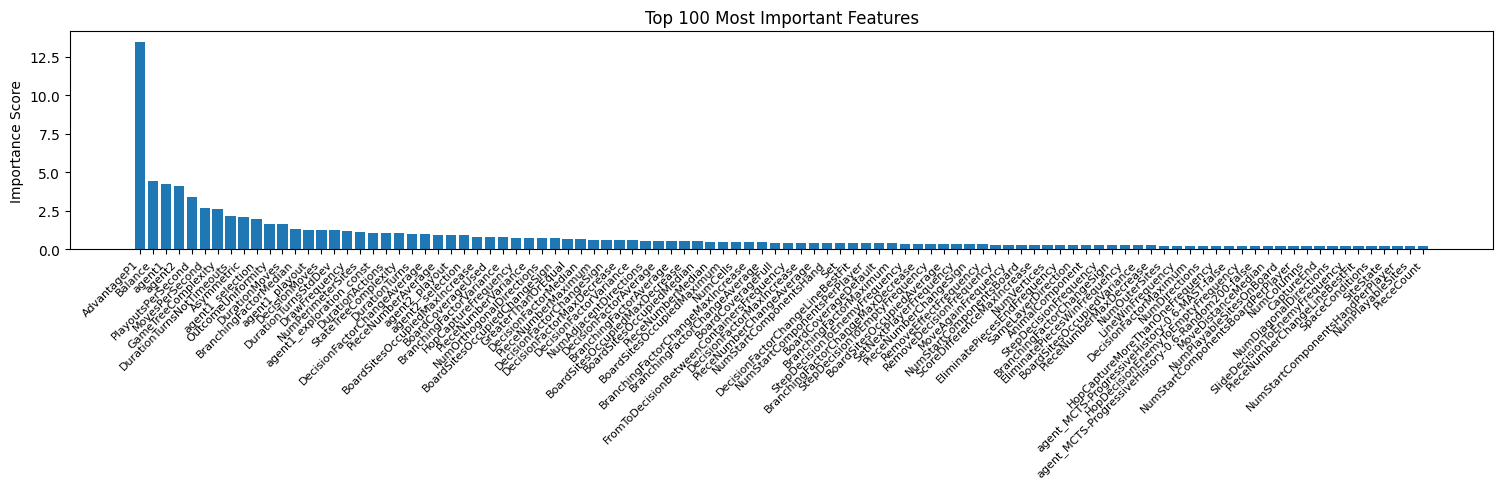

Fold 4 - RMSE: 0.4429191320170506
Fold 5


0:	learn: 0.6163988	test: 0.5423748	best: 0.5423748 (0)	total: 70.1ms	remaining: 3m 30s


50:	learn: 0.3929222	test: 0.4463221	best: 0.4463221 (50)	total: 4.11s	remaining: 3m 57s


100:	learn: 0.3536494	test: 0.4270727	best: 0.4270727 (100)	total: 8.39s	remaining: 4m


150:	learn: 0.3312684	test: 0.4195957	best: 0.4195957 (150)	total: 12.7s	remaining: 3m 59s


200:	learn: 0.3156824	test: 0.4149017	best: 0.4149017 (200)	total: 17s	remaining: 3m 56s


250:	learn: 0.3029196	test: 0.4117983	best: 0.4117983 (250)	total: 21.4s	remaining: 3m 54s


300:	learn: 0.2934978	test: 0.4105158	best: 0.4105061 (299)	total: 25.8s	remaining: 3m 51s


350:	learn: 0.2853345	test: 0.4094395	best: 0.4094395 (350)	total: 30.1s	remaining: 3m 46s


400:	learn: 0.2781172	test: 0.4081075	best: 0.4080969 (398)	total: 34.4s	remaining: 3m 42s


450:	learn: 0.2715912	test: 0.4079202	best: 0.4079202 (450)	total: 38.7s	remaining: 3m 38s


500:	learn: 0.2659824	test: 0.4072606	best: 0.4072606 (500)	total: 43s	remaining: 3m 34s


550:	learn: 0.2607254	test: 0.4066562	best: 0.4066189 (548)	total: 47.4s	remaining: 3m 30s


600:	learn: 0.2560972	test: 0.4062942	best: 0.4062942 (600)	total: 51.8s	remaining: 3m 26s


650:	learn: 0.2517997	test: 0.4055107	best: 0.4055107 (650)	total: 56.2s	remaining: 3m 22s


700:	learn: 0.2477470	test: 0.4050321	best: 0.4050321 (700)	total: 1m	remaining: 3m 18s


750:	learn: 0.2444718	test: 0.4049044	best: 0.4048947 (749)	total: 1m 4s	remaining: 3m 14s


800:	learn: 0.2412455	test: 0.4044586	best: 0.4044586 (800)	total: 1m 9s	remaining: 3m 10s


850:	learn: 0.2379645	test: 0.4043802	best: 0.4043464 (814)	total: 1m 13s	remaining: 3m 6s


900:	learn: 0.2350884	test: 0.4041932	best: 0.4041600 (894)	total: 1m 18s	remaining: 3m 2s


950:	learn: 0.2321052	test: 0.4040226	best: 0.4040226 (950)	total: 1m 22s	remaining: 2m 57s


1000:	learn: 0.2293360	test: 0.4039547	best: 0.4039380 (993)	total: 1m 26s	remaining: 2m 53s


1050:	learn: 0.2266840	test: 0.4038390	best: 0.4038123 (1044)	total: 1m 31s	remaining: 2m 49s


1100:	learn: 0.2243131	test: 0.4038282	best: 0.4037762 (1072)	total: 1m 35s	remaining: 2m 45s


1150:	learn: 0.2218774	test: 0.4037434	best: 0.4037238 (1120)	total: 1m 40s	remaining: 2m 41s


1200:	learn: 0.2195431	test: 0.4035263	best: 0.4035223 (1171)	total: 1m 44s	remaining: 2m 37s


1250:	learn: 0.2172471	test: 0.4033950	best: 0.4033950 (1250)	total: 1m 49s	remaining: 2m 32s


1300:	learn: 0.2152304	test: 0.4033933	best: 0.4033566 (1273)	total: 1m 53s	remaining: 2m 28s


1350:	learn: 0.2132314	test: 0.4033472	best: 0.4033327 (1318)	total: 1m 58s	remaining: 2m 24s


1400:	learn: 0.2111966	test: 0.4032072	best: 0.4032072 (1400)	total: 2m 2s	remaining: 2m 19s


1450:	learn: 0.2092441	test: 0.4031518	best: 0.4031518 (1450)	total: 2m 7s	remaining: 2m 15s


1500:	learn: 0.2073971	test: 0.4030414	best: 0.4030086 (1494)	total: 2m 11s	remaining: 2m 11s


1550:	learn: 0.2056339	test: 0.4028756	best: 0.4028736 (1534)	total: 2m 15s	remaining: 2m 6s


1600:	learn: 0.2038118	test: 0.4026702	best: 0.4026702 (1600)	total: 2m 20s	remaining: 2m 2s


1650:	learn: 0.2020512	test: 0.4026535	best: 0.4026471 (1641)	total: 2m 24s	remaining: 1m 58s


1700:	learn: 0.2003222	test: 0.4026200	best: 0.4026143 (1686)	total: 2m 29s	remaining: 1m 53s


1750:	learn: 0.1985687	test: 0.4026527	best: 0.4026143 (1686)	total: 2m 33s	remaining: 1m 49s


1800:	learn: 0.1969912	test: 0.4027318	best: 0.4026143 (1686)	total: 2m 37s	remaining: 1m 45s


1850:	learn: 0.1955082	test: 0.4027264	best: 0.4026143 (1686)	total: 2m 42s	remaining: 1m 40s


1900:	learn: 0.1939419	test: 0.4026953	best: 0.4026143 (1686)	total: 2m 46s	remaining: 1m 36s


1950:	learn: 0.1924356	test: 0.4026421	best: 0.4026143 (1686)	total: 2m 51s	remaining: 1m 32s


2000:	learn: 0.1908499	test: 0.4026597	best: 0.4025961 (1969)	total: 2m 55s	remaining: 1m 27s


2050:	learn: 0.1893835	test: 0.4027050	best: 0.4025961 (1969)	total: 3m	remaining: 1m 23s


2100:	learn: 0.1880199	test: 0.4026566	best: 0.4025961 (1969)	total: 3m 4s	remaining: 1m 18s


2150:	learn: 0.1865247	test: 0.4026624	best: 0.4025961 (1969)	total: 3m 8s	remaining: 1m 14s


2200:	learn: 0.1851691	test: 0.4027365	best: 0.4025961 (1969)	total: 3m 13s	remaining: 1m 10s


2250:	learn: 0.1837894	test: 0.4026699	best: 0.4025961 (1969)	total: 3m 17s	remaining: 1m 5s


2300:	learn: 0.1824889	test: 0.4026098	best: 0.4025961 (1969)	total: 3m 22s	remaining: 1m 1s


2350:	learn: 0.1812440	test: 0.4025795	best: 0.4025715 (2323)	total: 3m 26s	remaining: 57s


2400:	learn: 0.1799730	test: 0.4026390	best: 0.4025536 (2385)	total: 3m 31s	remaining: 52.7s


2450:	learn: 0.1786009	test: 0.4025469	best: 0.4025399 (2437)	total: 3m 35s	remaining: 48.3s


2500:	learn: 0.1773676	test: 0.4025081	best: 0.4024990 (2494)	total: 3m 39s	remaining: 43.9s


2550:	learn: 0.1760460	test: 0.4025700	best: 0.4024990 (2502)	total: 3m 44s	remaining: 39.5s


2600:	learn: 0.1747601	test: 0.4025454	best: 0.4024990 (2502)	total: 3m 48s	remaining: 35.1s


2650:	learn: 0.1735813	test: 0.4025133	best: 0.4024990 (2502)	total: 3m 53s	remaining: 30.7s


2700:	learn: 0.1725075	test: 0.4025935	best: 0.4024969 (2654)	total: 3m 57s	remaining: 26.3s


2750:	learn: 0.1714193	test: 0.4025882	best: 0.4024969 (2654)	total: 4m 2s	remaining: 21.9s


2800:	learn: 0.1703113	test: 0.4026519	best: 0.4024969 (2654)	total: 4m 6s	remaining: 17.5s


2850:	learn: 0.1691073	test: 0.4026641	best: 0.4024969 (2654)	total: 4m 10s	remaining: 13.1s


2900:	learn: 0.1680874	test: 0.4026698	best: 0.4024969 (2654)	total: 4m 15s	remaining: 8.71s


2950:	learn: 0.1670230	test: 0.4027374	best: 0.4024969 (2654)	total: 4m 19s	remaining: 4.31s


2999:	learn: 0.1660626	test: 0.4027184	best: 0.4024969 (2654)	total: 4m 24s	remaining: 0us

bestTest = 0.402496912
bestIteration = 2654

Shrink model to first 2655 iterations.


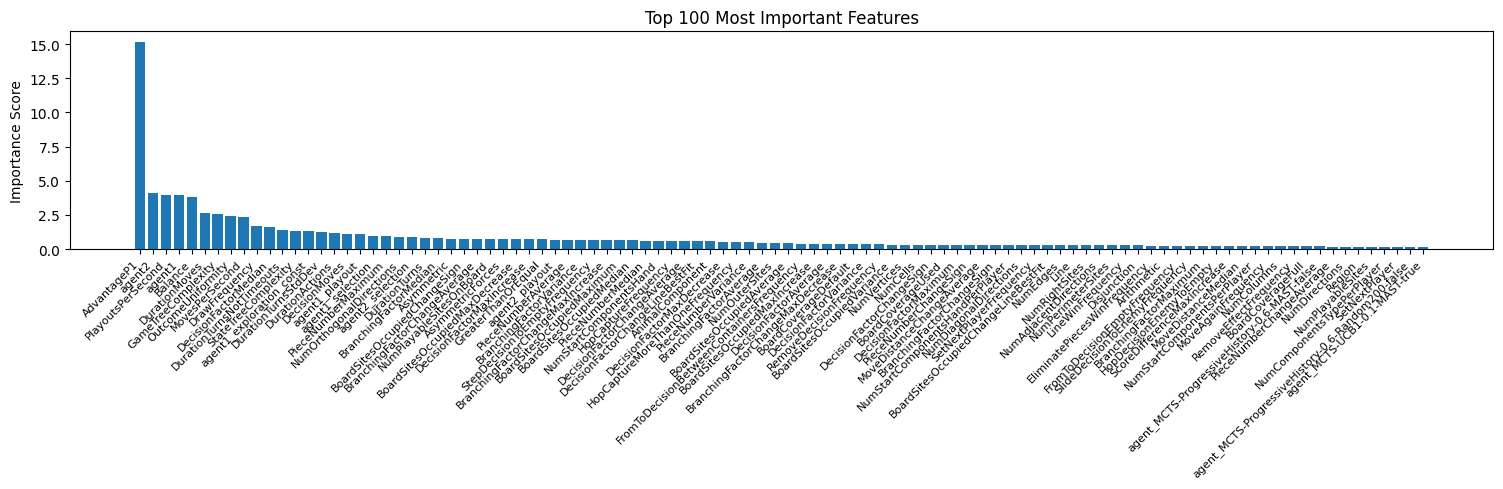

Fold 5 - RMSE: 0.4020487971991141
List of oof scores: [0.42090325598542655, 0.43817295457324834, 0.43109219280577804, 0.4429191320170506, 0.4020487971991141]
Average oof score: 0.4270272665161235


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6160733	test: 0.5317173	best: 0.5317173 (0)	total: 79ms	remaining: 3m 57s


50:	learn: 0.3939812	test: 0.4489100	best: 0.4489100 (50)	total: 4.25s	remaining: 4m 5s


100:	learn: 0.3517742	test: 0.4306247	best: 0.4306247 (100)	total: 8.72s	remaining: 4m 10s


150:	learn: 0.3267639	test: 0.4246713	best: 0.4246600 (149)	total: 13s	remaining: 4m 5s


200:	learn: 0.3117637	test: 0.4218453	best: 0.4218060 (189)	total: 17.3s	remaining: 4m 1s


250:	learn: 0.2993704	test: 0.4191924	best: 0.4191924 (250)	total: 21.6s	remaining: 3m 56s


300:	learn: 0.2900843	test: 0.4176417	best: 0.4176135 (299)	total: 26s	remaining: 3m 53s


350:	learn: 0.2812592	test: 0.4153520	best: 0.4153520 (350)	total: 30.3s	remaining: 3m 48s


400:	learn: 0.2743839	test: 0.4138437	best: 0.4138437 (400)	total: 34.7s	remaining: 3m 44s


450:	learn: 0.2680778	test: 0.4130445	best: 0.4130445 (450)	total: 39s	remaining: 3m 40s


500:	learn: 0.2626030	test: 0.4123600	best: 0.4123600 (500)	total: 43.5s	remaining: 3m 36s


550:	learn: 0.2576567	test: 0.4117287	best: 0.4117287 (550)	total: 47.9s	remaining: 3m 32s


600:	learn: 0.2528581	test: 0.4108823	best: 0.4108823 (600)	total: 52.3s	remaining: 3m 28s


650:	learn: 0.2488161	test: 0.4104781	best: 0.4104781 (650)	total: 56.7s	remaining: 3m 24s


700:	learn: 0.2449826	test: 0.4099503	best: 0.4099211 (685)	total: 1m 1s	remaining: 3m 20s


750:	learn: 0.2411960	test: 0.4094293	best: 0.4094273 (749)	total: 1m 5s	remaining: 3m 16s


800:	learn: 0.2376494	test: 0.4093171	best: 0.4092999 (799)	total: 1m 9s	remaining: 3m 11s


850:	learn: 0.2343331	test: 0.4088629	best: 0.4088608 (849)	total: 1m 14s	remaining: 3m 7s


900:	learn: 0.2311029	test: 0.4086102	best: 0.4086049 (895)	total: 1m 18s	remaining: 3m 3s


950:	learn: 0.2281564	test: 0.4084635	best: 0.4084527 (942)	total: 1m 23s	remaining: 2m 58s


1000:	learn: 0.2256571	test: 0.4083346	best: 0.4083346 (1000)	total: 1m 27s	remaining: 2m 54s


1050:	learn: 0.2231526	test: 0.4081205	best: 0.4081186 (1049)	total: 1m 31s	remaining: 2m 50s


1100:	learn: 0.2206941	test: 0.4080640	best: 0.4080457 (1063)	total: 1m 36s	remaining: 2m 46s


1150:	learn: 0.2184426	test: 0.4081354	best: 0.4080457 (1063)	total: 1m 40s	remaining: 2m 41s


1200:	learn: 0.2162505	test: 0.4080120	best: 0.4079916 (1195)	total: 1m 45s	remaining: 2m 37s


1250:	learn: 0.2141519	test: 0.4079274	best: 0.4079120 (1245)	total: 1m 49s	remaining: 2m 33s


1300:	learn: 0.2119556	test: 0.4077219	best: 0.4077219 (1300)	total: 1m 53s	remaining: 2m 28s


1350:	learn: 0.2100976	test: 0.4075296	best: 0.4075296 (1350)	total: 1m 58s	remaining: 2m 24s


1400:	learn: 0.2081390	test: 0.4074979	best: 0.4074843 (1385)	total: 2m 2s	remaining: 2m 20s


1450:	learn: 0.2063925	test: 0.4075339	best: 0.4074803 (1417)	total: 2m 7s	remaining: 2m 16s


1500:	learn: 0.2046992	test: 0.4074297	best: 0.4074297 (1500)	total: 2m 11s	remaining: 2m 11s


1550:	learn: 0.2029802	test: 0.4074595	best: 0.4074167 (1504)	total: 2m 16s	remaining: 2m 7s


1600:	learn: 0.2012104	test: 0.4073796	best: 0.4073342 (1580)	total: 2m 20s	remaining: 2m 3s


1650:	learn: 0.1995415	test: 0.4072875	best: 0.4072703 (1637)	total: 2m 25s	remaining: 1m 58s


1700:	learn: 0.1977895	test: 0.4071521	best: 0.4071473 (1699)	total: 2m 29s	remaining: 1m 54s


1750:	learn: 0.1962010	test: 0.4070891	best: 0.4070872 (1746)	total: 2m 34s	remaining: 1m 49s


1800:	learn: 0.1946972	test: 0.4070216	best: 0.4070216 (1800)	total: 2m 38s	remaining: 1m 45s


1850:	learn: 0.1930382	test: 0.4069859	best: 0.4069735 (1847)	total: 2m 42s	remaining: 1m 41s


1900:	learn: 0.1914037	test: 0.4070448	best: 0.4069498 (1856)	total: 2m 47s	remaining: 1m 36s


1950:	learn: 0.1899808	test: 0.4070227	best: 0.4069498 (1856)	total: 2m 51s	remaining: 1m 32s


2000:	learn: 0.1884573	test: 0.4068808	best: 0.4068808 (2000)	total: 2m 56s	remaining: 1m 27s


2050:	learn: 0.1869442	test: 0.4068474	best: 0.4068474 (2050)	total: 3m	remaining: 1m 23s


2100:	learn: 0.1856253	test: 0.4067524	best: 0.4067487 (2097)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.1842996	test: 0.4067929	best: 0.4067142 (2128)	total: 3m 9s	remaining: 1m 14s


2200:	learn: 0.1829965	test: 0.4068004	best: 0.4067142 (2128)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.1817751	test: 0.4067316	best: 0.4067142 (2128)	total: 3m 18s	remaining: 1m 6s


2300:	learn: 0.1805547	test: 0.4066874	best: 0.4066874 (2300)	total: 3m 22s	remaining: 1m 1s


2350:	learn: 0.1792704	test: 0.4067228	best: 0.4066808 (2303)	total: 3m 27s	remaining: 57.2s


2400:	learn: 0.1781283	test: 0.4066667	best: 0.4066649 (2398)	total: 3m 31s	remaining: 52.9s


2450:	learn: 0.1769113	test: 0.4066295	best: 0.4066271 (2437)	total: 3m 36s	remaining: 48.5s


2500:	learn: 0.1757901	test: 0.4065949	best: 0.4065831 (2495)	total: 3m 40s	remaining: 44s


2550:	learn: 0.1745781	test: 0.4066349	best: 0.4065831 (2495)	total: 3m 45s	remaining: 39.6s


2600:	learn: 0.1733694	test: 0.4066810	best: 0.4065831 (2495)	total: 3m 49s	remaining: 35.2s


2650:	learn: 0.1722141	test: 0.4066267	best: 0.4065831 (2495)	total: 3m 54s	remaining: 30.8s


2700:	learn: 0.1710702	test: 0.4065898	best: 0.4065831 (2495)	total: 3m 58s	remaining: 26.4s


2750:	learn: 0.1697507	test: 0.4065739	best: 0.4065739 (2750)	total: 4m 2s	remaining: 22s


2800:	learn: 0.1686088	test: 0.4065395	best: 0.4065277 (2793)	total: 4m 7s	remaining: 17.6s


2850:	learn: 0.1675546	test: 0.4065163	best: 0.4065090 (2836)	total: 4m 11s	remaining: 13.2s


2900:	learn: 0.1663969	test: 0.4064561	best: 0.4064561 (2900)	total: 4m 16s	remaining: 8.75s


2950:	learn: 0.1653575	test: 0.4064496	best: 0.4064347 (2932)	total: 4m 20s	remaining: 4.33s


2999:	learn: 0.1642572	test: 0.4064546	best: 0.4063958 (2976)	total: 4m 24s	remaining: 0us

bestTest = 0.4063958189
bestIteration = 2976

Shrink model to first 2977 iterations.


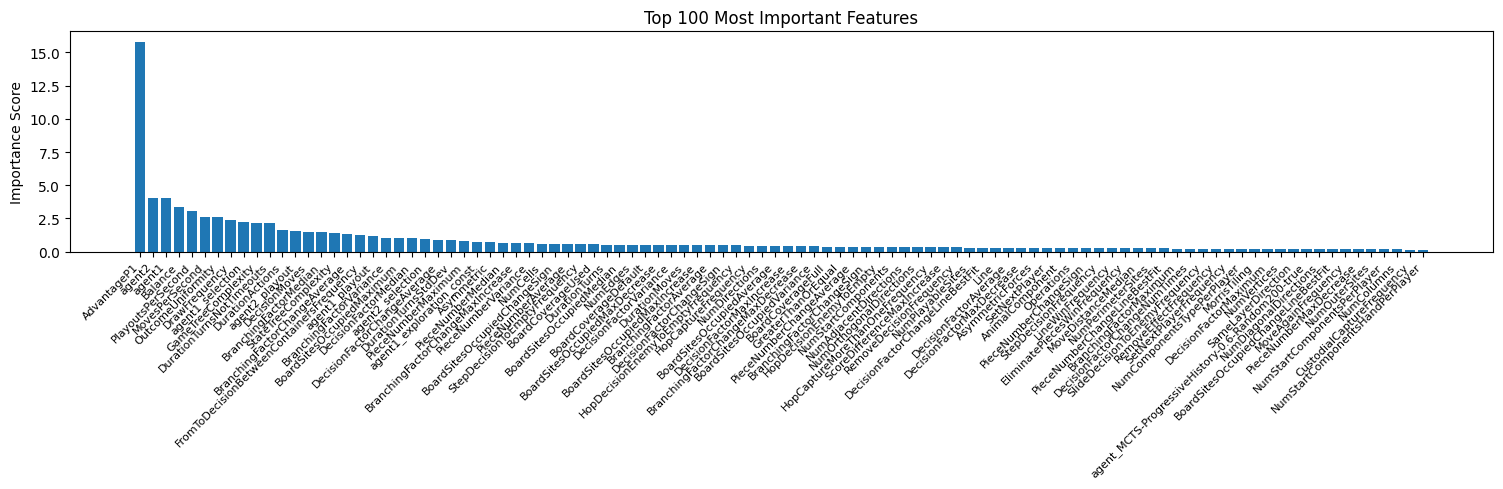

Fold 1 - RMSE: 0.4060771588058601
Fold 2


0:	learn: 0.6137397	test: 0.5357632	best: 0.5357632 (0)	total: 82.8ms	remaining: 4m 8s


50:	learn: 0.3911563	test: 0.4244869	best: 0.4244869 (50)	total: 4.26s	remaining: 4m 6s


100:	learn: 0.3480412	test: 0.4098128	best: 0.4098128 (100)	total: 8.72s	remaining: 4m 10s


150:	learn: 0.3251510	test: 0.4050599	best: 0.4050599 (150)	total: 13.1s	remaining: 4m 6s


200:	learn: 0.3103068	test: 0.4021234	best: 0.4021234 (200)	total: 17.5s	remaining: 4m 3s


250:	learn: 0.2985617	test: 0.4003523	best: 0.4003523 (250)	total: 21.8s	remaining: 3m 58s


300:	learn: 0.2888525	test: 0.3992776	best: 0.3992776 (300)	total: 26.2s	remaining: 3m 55s


350:	learn: 0.2807182	test: 0.3985779	best: 0.3984927 (349)	total: 30.7s	remaining: 3m 51s


400:	learn: 0.2737839	test: 0.3978246	best: 0.3977746 (397)	total: 35s	remaining: 3m 46s


450:	learn: 0.2676125	test: 0.3974083	best: 0.3973990 (446)	total: 39.4s	remaining: 3m 42s


500:	learn: 0.2623669	test: 0.3970237	best: 0.3969988 (494)	total: 43.9s	remaining: 3m 38s


550:	learn: 0.2570541	test: 0.3971526	best: 0.3969762 (511)	total: 48.3s	remaining: 3m 34s


600:	learn: 0.2528118	test: 0.3967562	best: 0.3967562 (600)	total: 52.8s	remaining: 3m 30s


650:	learn: 0.2483742	test: 0.3965951	best: 0.3965569 (645)	total: 57.2s	remaining: 3m 26s


700:	learn: 0.2447533	test: 0.3965208	best: 0.3964751 (675)	total: 1m 1s	remaining: 3m 22s


750:	learn: 0.2410062	test: 0.3965744	best: 0.3964697 (726)	total: 1m 6s	remaining: 3m 17s


800:	learn: 0.2378307	test: 0.3965742	best: 0.3964697 (726)	total: 1m 10s	remaining: 3m 13s


850:	learn: 0.2344545	test: 0.3964310	best: 0.3964310 (850)	total: 1m 14s	remaining: 3m 9s


900:	learn: 0.2315293	test: 0.3963677	best: 0.3962992 (884)	total: 1m 19s	remaining: 3m 4s


950:	learn: 0.2287400	test: 0.3963051	best: 0.3962906 (949)	total: 1m 23s	remaining: 3m


1000:	learn: 0.2260344	test: 0.3960497	best: 0.3960348 (998)	total: 1m 28s	remaining: 2m 56s


1050:	learn: 0.2232835	test: 0.3958894	best: 0.3958675 (1047)	total: 1m 32s	remaining: 2m 51s


1100:	learn: 0.2209566	test: 0.3958555	best: 0.3958073 (1090)	total: 1m 37s	remaining: 2m 47s


1150:	learn: 0.2186655	test: 0.3957481	best: 0.3957229 (1148)	total: 1m 41s	remaining: 2m 43s


1200:	learn: 0.2166351	test: 0.3957094	best: 0.3956496 (1176)	total: 1m 46s	remaining: 2m 38s


1250:	learn: 0.2144518	test: 0.3957029	best: 0.3956496 (1176)	total: 1m 50s	remaining: 2m 34s


1300:	learn: 0.2125002	test: 0.3956400	best: 0.3956390 (1299)	total: 1m 55s	remaining: 2m 30s


1350:	learn: 0.2107328	test: 0.3955890	best: 0.3955770 (1345)	total: 1m 59s	remaining: 2m 25s


1400:	learn: 0.2086525	test: 0.3955575	best: 0.3955466 (1391)	total: 2m 4s	remaining: 2m 21s


1450:	learn: 0.2069091	test: 0.3956114	best: 0.3955466 (1391)	total: 2m 8s	remaining: 2m 17s


1500:	learn: 0.2049292	test: 0.3956757	best: 0.3955466 (1391)	total: 2m 13s	remaining: 2m 12s


1550:	learn: 0.2030215	test: 0.3957223	best: 0.3955466 (1391)	total: 2m 17s	remaining: 2m 8s


1600:	learn: 0.2013590	test: 0.3956333	best: 0.3955466 (1391)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.1996192	test: 0.3956950	best: 0.3955466 (1391)	total: 2m 26s	remaining: 1m 59s


1700:	learn: 0.1980428	test: 0.3956778	best: 0.3955466 (1391)	total: 2m 31s	remaining: 1m 55s


1750:	learn: 0.1962918	test: 0.3956824	best: 0.3955466 (1391)	total: 2m 35s	remaining: 1m 50s


1800:	learn: 0.1947297	test: 0.3957222	best: 0.3955466 (1391)	total: 2m 40s	remaining: 1m 46s


1850:	learn: 0.1932403	test: 0.3956833	best: 0.3955466 (1391)	total: 2m 44s	remaining: 1m 42s


1900:	learn: 0.1916980	test: 0.3957783	best: 0.3955466 (1391)	total: 2m 48s	remaining: 1m 37s


1950:	learn: 0.1901940	test: 0.3958836	best: 0.3955466 (1391)	total: 2m 53s	remaining: 1m 33s


2000:	learn: 0.1888622	test: 0.3958704	best: 0.3955466 (1391)	total: 2m 58s	remaining: 1m 28s


2050:	learn: 0.1874077	test: 0.3958124	best: 0.3955466 (1391)	total: 3m 2s	remaining: 1m 24s


2100:	learn: 0.1859335	test: 0.3957934	best: 0.3955466 (1391)	total: 3m 6s	remaining: 1m 20s


2150:	learn: 0.1845384	test: 0.3958790	best: 0.3955466 (1391)	total: 3m 11s	remaining: 1m 15s


2200:	learn: 0.1831670	test: 0.3959298	best: 0.3955466 (1391)	total: 3m 15s	remaining: 1m 11s


2250:	learn: 0.1819483	test: 0.3959299	best: 0.3955466 (1391)	total: 3m 20s	remaining: 1m 6s


2300:	learn: 0.1806926	test: 0.3959200	best: 0.3955466 (1391)	total: 3m 24s	remaining: 1m 2s


2350:	learn: 0.1794476	test: 0.3959355	best: 0.3955466 (1391)	total: 3m 29s	remaining: 57.8s


2400:	learn: 0.1783230	test: 0.3959559	best: 0.3955466 (1391)	total: 3m 34s	remaining: 53.4s


2450:	learn: 0.1770890	test: 0.3958848	best: 0.3955466 (1391)	total: 3m 38s	remaining: 49s


2500:	learn: 0.1758790	test: 0.3959693	best: 0.3955466 (1391)	total: 3m 42s	remaining: 44.5s


2550:	learn: 0.1746907	test: 0.3960593	best: 0.3955466 (1391)	total: 3m 47s	remaining: 40s


2600:	learn: 0.1735400	test: 0.3960983	best: 0.3955466 (1391)	total: 3m 52s	remaining: 35.6s


2650:	learn: 0.1724642	test: 0.3960957	best: 0.3955466 (1391)	total: 3m 56s	remaining: 31.1s


2700:	learn: 0.1713283	test: 0.3961580	best: 0.3955466 (1391)	total: 4m 1s	remaining: 26.7s


2750:	learn: 0.1702614	test: 0.3961562	best: 0.3955466 (1391)	total: 4m 5s	remaining: 22.2s


2800:	learn: 0.1691221	test: 0.3962060	best: 0.3955466 (1391)	total: 4m 10s	remaining: 17.8s


2850:	learn: 0.1680372	test: 0.3962392	best: 0.3955466 (1391)	total: 4m 14s	remaining: 13.3s


2900:	learn: 0.1669760	test: 0.3962231	best: 0.3955466 (1391)	total: 4m 19s	remaining: 8.84s


2950:	learn: 0.1658705	test: 0.3962287	best: 0.3955466 (1391)	total: 4m 23s	remaining: 4.37s


2999:	learn: 0.1649190	test: 0.3962274	best: 0.3955466 (1391)	total: 4m 27s	remaining: 0us

bestTest = 0.3955466265
bestIteration = 1391

Shrink model to first 1392 iterations.


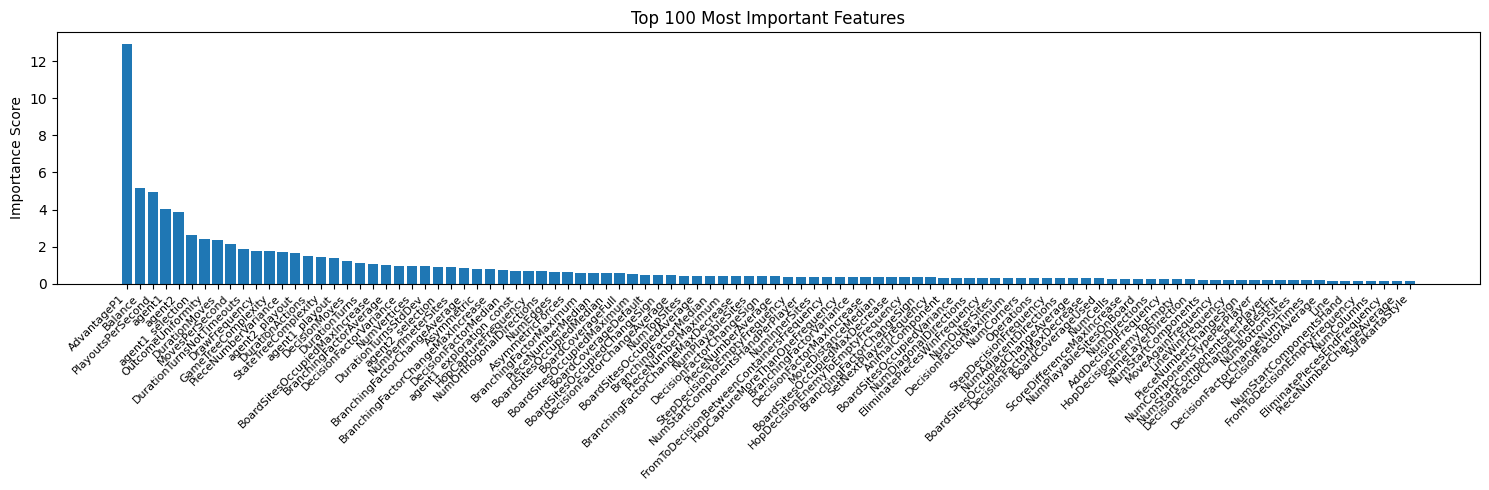

Fold 2 - RMSE: 0.3950845574692823
Fold 3


0:	learn: 0.5997897	test: 0.6087849	best: 0.6087849 (0)	total: 81.3ms	remaining: 4m 3s


50:	learn: 0.3809877	test: 0.4814417	best: 0.4814417 (50)	total: 4.29s	remaining: 4m 7s


100:	learn: 0.3408173	test: 0.4605940	best: 0.4605940 (100)	total: 8.79s	remaining: 4m 12s


150:	learn: 0.3183808	test: 0.4511504	best: 0.4511504 (150)	total: 13.2s	remaining: 4m 8s


200:	learn: 0.3032323	test: 0.4468230	best: 0.4467997 (199)	total: 17.6s	remaining: 4m 5s


250:	learn: 0.2918955	test: 0.4432109	best: 0.4432109 (250)	total: 22.1s	remaining: 4m 1s


300:	learn: 0.2831296	test: 0.4413395	best: 0.4413395 (300)	total: 26.4s	remaining: 3m 57s


350:	learn: 0.2757208	test: 0.4399112	best: 0.4399066 (347)	total: 30.9s	remaining: 3m 52s


400:	learn: 0.2689483	test: 0.4384058	best: 0.4384058 (400)	total: 35.3s	remaining: 3m 48s


450:	learn: 0.2632930	test: 0.4372760	best: 0.4372620 (448)	total: 39.7s	remaining: 3m 44s


500:	learn: 0.2582185	test: 0.4362247	best: 0.4362215 (498)	total: 44.2s	remaining: 3m 40s


550:	learn: 0.2534193	test: 0.4352762	best: 0.4352343 (547)	total: 48.6s	remaining: 3m 36s


600:	learn: 0.2487867	test: 0.4345891	best: 0.4345597 (598)	total: 53s	remaining: 3m 31s


650:	learn: 0.2447930	test: 0.4338518	best: 0.4338012 (646)	total: 57.5s	remaining: 3m 27s


700:	learn: 0.2413564	test: 0.4334904	best: 0.4334787 (699)	total: 1m 2s	remaining: 3m 23s


750:	learn: 0.2379529	test: 0.4331913	best: 0.4331888 (748)	total: 1m 6s	remaining: 3m 19s


800:	learn: 0.2348686	test: 0.4327698	best: 0.4327046 (795)	total: 1m 11s	remaining: 3m 15s


850:	learn: 0.2318158	test: 0.4326591	best: 0.4326091 (833)	total: 1m 15s	remaining: 3m 11s


900:	learn: 0.2291721	test: 0.4323291	best: 0.4323291 (900)	total: 1m 20s	remaining: 3m 6s


950:	learn: 0.2264490	test: 0.4319967	best: 0.4319967 (950)	total: 1m 24s	remaining: 3m 2s


1000:	learn: 0.2240636	test: 0.4317052	best: 0.4316871 (994)	total: 1m 29s	remaining: 2m 58s


1050:	learn: 0.2216557	test: 0.4313542	best: 0.4313542 (1050)	total: 1m 33s	remaining: 2m 53s


1100:	learn: 0.2194596	test: 0.4312141	best: 0.4311494 (1092)	total: 1m 38s	remaining: 2m 49s


1150:	learn: 0.2172931	test: 0.4310560	best: 0.4310560 (1150)	total: 1m 42s	remaining: 2m 45s


1200:	learn: 0.2151646	test: 0.4309672	best: 0.4309579 (1189)	total: 1m 47s	remaining: 2m 40s


1250:	learn: 0.2131292	test: 0.4307177	best: 0.4307177 (1250)	total: 1m 51s	remaining: 2m 36s


1300:	learn: 0.2110846	test: 0.4306252	best: 0.4306142 (1295)	total: 1m 56s	remaining: 2m 31s


1350:	learn: 0.2091420	test: 0.4305267	best: 0.4305267 (1350)	total: 2m	remaining: 2m 27s


1400:	learn: 0.2071887	test: 0.4304609	best: 0.4304397 (1388)	total: 2m 5s	remaining: 2m 23s


1450:	learn: 0.2053872	test: 0.4303957	best: 0.4303915 (1443)	total: 2m 9s	remaining: 2m 18s


1500:	learn: 0.2035832	test: 0.4303766	best: 0.4303597 (1461)	total: 2m 14s	remaining: 2m 14s


1550:	learn: 0.2017807	test: 0.4303219	best: 0.4303147 (1539)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2000773	test: 0.4302169	best: 0.4302169 (1600)	total: 2m 23s	remaining: 2m 5s


1650:	learn: 0.1984990	test: 0.4300601	best: 0.4300601 (1650)	total: 2m 28s	remaining: 2m 1s


1700:	learn: 0.1967950	test: 0.4299225	best: 0.4299225 (1700)	total: 2m 32s	remaining: 1m 56s


1750:	learn: 0.1951478	test: 0.4299336	best: 0.4299225 (1700)	total: 2m 37s	remaining: 1m 52s


1800:	learn: 0.1936446	test: 0.4298579	best: 0.4298366 (1793)	total: 2m 41s	remaining: 1m 47s


1850:	learn: 0.1921296	test: 0.4297181	best: 0.4297135 (1846)	total: 2m 46s	remaining: 1m 43s


1900:	learn: 0.1907458	test: 0.4296527	best: 0.4296363 (1893)	total: 2m 50s	remaining: 1m 38s


1950:	learn: 0.1894225	test: 0.4296137	best: 0.4296137 (1950)	total: 2m 55s	remaining: 1m 34s


2000:	learn: 0.1880862	test: 0.4295912	best: 0.4295803 (1976)	total: 2m 59s	remaining: 1m 29s


2050:	learn: 0.1866140	test: 0.4295626	best: 0.4295533 (2043)	total: 3m 4s	remaining: 1m 25s


2100:	learn: 0.1852316	test: 0.4295035	best: 0.4295035 (2100)	total: 3m 8s	remaining: 1m 20s


2150:	learn: 0.1838799	test: 0.4294902	best: 0.4294875 (2149)	total: 3m 13s	remaining: 1m 16s


2200:	learn: 0.1825506	test: 0.4293434	best: 0.4293434 (2200)	total: 3m 18s	remaining: 1m 11s


2250:	learn: 0.1812559	test: 0.4293242	best: 0.4292951 (2241)	total: 3m 22s	remaining: 1m 7s


2300:	learn: 0.1799329	test: 0.4292845	best: 0.4292582 (2291)	total: 3m 27s	remaining: 1m 2s


2350:	learn: 0.1786925	test: 0.4292566	best: 0.4292360 (2342)	total: 3m 31s	remaining: 58.5s


2400:	learn: 0.1774402	test: 0.4292490	best: 0.4292360 (2342)	total: 3m 36s	remaining: 54s


2450:	learn: 0.1761873	test: 0.4292350	best: 0.4291982 (2436)	total: 3m 40s	remaining: 49.5s


2500:	learn: 0.1750222	test: 0.4292196	best: 0.4291982 (2436)	total: 3m 45s	remaining: 45s


2550:	learn: 0.1740195	test: 0.4292165	best: 0.4291982 (2436)	total: 3m 49s	remaining: 40.5s


2600:	learn: 0.1728530	test: 0.4292216	best: 0.4291916 (2566)	total: 3m 54s	remaining: 36s


2650:	learn: 0.1717309	test: 0.4291915	best: 0.4291819 (2647)	total: 3m 58s	remaining: 31.5s


2700:	learn: 0.1705791	test: 0.4292325	best: 0.4291819 (2647)	total: 4m 3s	remaining: 27s


2750:	learn: 0.1693899	test: 0.4291772	best: 0.4291687 (2742)	total: 4m 7s	remaining: 22.4s


2800:	learn: 0.1682966	test: 0.4291530	best: 0.4291193 (2776)	total: 4m 12s	remaining: 17.9s


2850:	learn: 0.1672380	test: 0.4291723	best: 0.4291193 (2776)	total: 4m 17s	remaining: 13.4s


2900:	learn: 0.1662458	test: 0.4290898	best: 0.4290787 (2894)	total: 4m 21s	remaining: 8.93s


2950:	learn: 0.1652373	test: 0.4291045	best: 0.4290787 (2894)	total: 4m 26s	remaining: 4.42s


2999:	learn: 0.1641763	test: 0.4290643	best: 0.4290556 (2989)	total: 4m 30s	remaining: 0us

bestTest = 0.4290556026
bestIteration = 2989

Shrink model to first 2990 iterations.


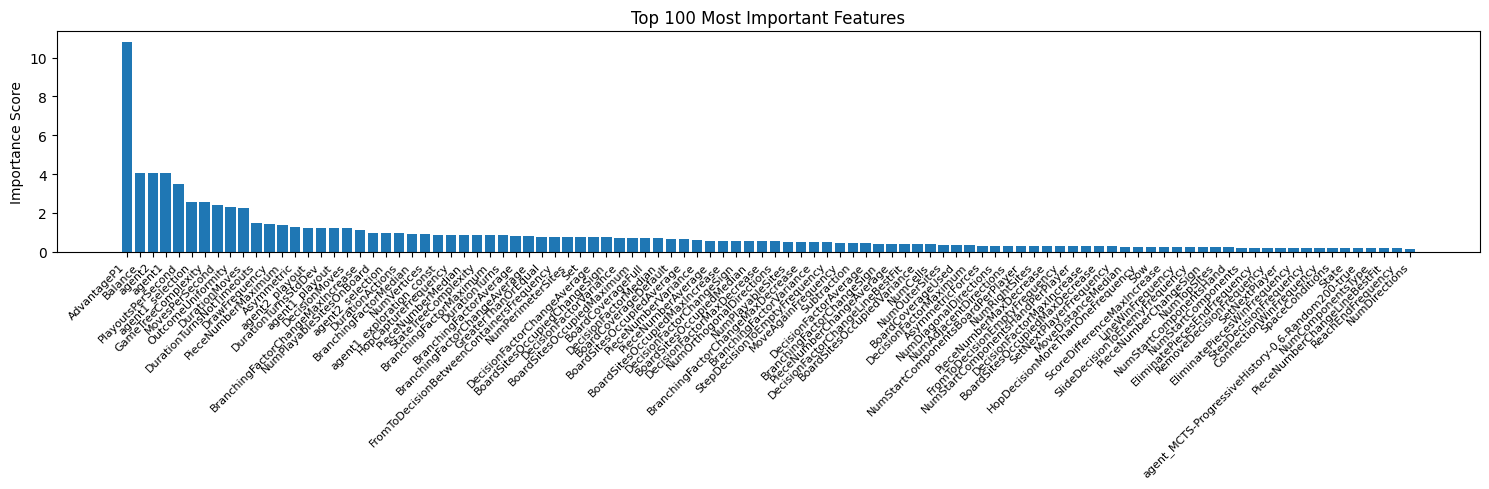

Fold 3 - RMSE: 0.42838373937284363
Fold 4


0:	learn: 0.6032678	test: 0.5983363	best: 0.5983363 (0)	total: 83ms	remaining: 4m 8s


50:	learn: 0.3890630	test: 0.4766080	best: 0.4766080 (50)	total: 4.38s	remaining: 4m 13s


100:	learn: 0.3490463	test: 0.4599750	best: 0.4599750 (100)	total: 8.98s	remaining: 4m 17s


150:	learn: 0.3258286	test: 0.4516959	best: 0.4516959 (150)	total: 13.5s	remaining: 4m 13s


200:	learn: 0.3112514	test: 0.4481718	best: 0.4481508 (192)	total: 18s	remaining: 4m 10s


250:	learn: 0.3002894	test: 0.4457702	best: 0.4456928 (248)	total: 22.4s	remaining: 4m 5s


300:	learn: 0.2911170	test: 0.4443924	best: 0.4443924 (300)	total: 26.9s	remaining: 4m 1s


350:	learn: 0.2836358	test: 0.4432410	best: 0.4432410 (350)	total: 31.3s	remaining: 3m 56s


400:	learn: 0.2761770	test: 0.4424344	best: 0.4424344 (400)	total: 35.8s	remaining: 3m 52s


450:	learn: 0.2703696	test: 0.4409929	best: 0.4409929 (450)	total: 40.2s	remaining: 3m 47s


500:	learn: 0.2649279	test: 0.4401728	best: 0.4401492 (498)	total: 44.7s	remaining: 3m 43s


550:	learn: 0.2600202	test: 0.4396217	best: 0.4396217 (550)	total: 49.2s	remaining: 3m 38s


600:	learn: 0.2556821	test: 0.4393821	best: 0.4393267 (593)	total: 53.8s	remaining: 3m 34s


650:	learn: 0.2517148	test: 0.4390029	best: 0.4390029 (650)	total: 58.3s	remaining: 3m 30s


700:	learn: 0.2480314	test: 0.4383324	best: 0.4383085 (696)	total: 1m 2s	remaining: 3m 26s


750:	learn: 0.2444011	test: 0.4380104	best: 0.4379665 (747)	total: 1m 7s	remaining: 3m 21s


800:	learn: 0.2408919	test: 0.4378537	best: 0.4378055 (794)	total: 1m 11s	remaining: 3m 17s


850:	learn: 0.2375420	test: 0.4375292	best: 0.4374962 (847)	total: 1m 16s	remaining: 3m 12s


900:	learn: 0.2347054	test: 0.4371539	best: 0.4371539 (900)	total: 1m 20s	remaining: 3m 8s


950:	learn: 0.2318784	test: 0.4369911	best: 0.4369508 (924)	total: 1m 25s	remaining: 3m 4s


1000:	learn: 0.2292688	test: 0.4366194	best: 0.4366194 (1000)	total: 1m 30s	remaining: 2m 59s


1050:	learn: 0.2267019	test: 0.4364064	best: 0.4363870 (1048)	total: 1m 34s	remaining: 2m 55s


1100:	learn: 0.2243138	test: 0.4361166	best: 0.4361157 (1099)	total: 1m 39s	remaining: 2m 51s


1150:	learn: 0.2220680	test: 0.4360546	best: 0.4360356 (1138)	total: 1m 43s	remaining: 2m 46s


1200:	learn: 0.2199035	test: 0.4360356	best: 0.4359933 (1168)	total: 1m 48s	remaining: 2m 42s


1250:	learn: 0.2177539	test: 0.4358931	best: 0.4358931 (1250)	total: 1m 52s	remaining: 2m 37s


1300:	learn: 0.2156254	test: 0.4358561	best: 0.4358197 (1298)	total: 1m 57s	remaining: 2m 33s


1350:	learn: 0.2136231	test: 0.4358059	best: 0.4357372 (1334)	total: 2m 1s	remaining: 2m 28s


1400:	learn: 0.2118400	test: 0.4358670	best: 0.4357372 (1334)	total: 2m 6s	remaining: 2m 24s


1450:	learn: 0.2099191	test: 0.4357413	best: 0.4357372 (1334)	total: 2m 11s	remaining: 2m 20s


1500:	learn: 0.2080984	test: 0.4356658	best: 0.4355950 (1486)	total: 2m 15s	remaining: 2m 15s


1550:	learn: 0.2062701	test: 0.4355177	best: 0.4355152 (1549)	total: 2m 20s	remaining: 2m 10s


1600:	learn: 0.2043645	test: 0.4356124	best: 0.4354178 (1578)	total: 2m 24s	remaining: 2m 6s


1650:	learn: 0.2027784	test: 0.4355088	best: 0.4354178 (1578)	total: 2m 29s	remaining: 2m 1s


1700:	learn: 0.2011251	test: 0.4354526	best: 0.4354178 (1578)	total: 2m 33s	remaining: 1m 57s


1750:	learn: 0.1995906	test: 0.4353324	best: 0.4353000 (1732)	total: 2m 38s	remaining: 1m 52s


1800:	learn: 0.1980572	test: 0.4351205	best: 0.4351197 (1797)	total: 2m 42s	remaining: 1m 48s


1850:	learn: 0.1965929	test: 0.4350035	best: 0.4349815 (1841)	total: 2m 47s	remaining: 1m 43s


1900:	learn: 0.1950105	test: 0.4349580	best: 0.4349167 (1891)	total: 2m 51s	remaining: 1m 39s


1950:	learn: 0.1934459	test: 0.4348748	best: 0.4348549 (1944)	total: 2m 56s	remaining: 1m 34s


2000:	learn: 0.1920393	test: 0.4348559	best: 0.4348351 (1980)	total: 3m	remaining: 1m 30s


2050:	learn: 0.1906462	test: 0.4348154	best: 0.4348026 (2039)	total: 3m 5s	remaining: 1m 25s


2100:	learn: 0.1892715	test: 0.4347938	best: 0.4347783 (2088)	total: 3m 10s	remaining: 1m 21s


2150:	learn: 0.1877876	test: 0.4347338	best: 0.4347338 (2150)	total: 3m 14s	remaining: 1m 16s


2200:	learn: 0.1863318	test: 0.4346694	best: 0.4346608 (2199)	total: 3m 19s	remaining: 1m 12s


2250:	learn: 0.1849344	test: 0.4347283	best: 0.4346493 (2207)	total: 3m 23s	remaining: 1m 7s


2300:	learn: 0.1836493	test: 0.4345854	best: 0.4345854 (2300)	total: 3m 28s	remaining: 1m 3s


2350:	learn: 0.1822985	test: 0.4344829	best: 0.4344616 (2344)	total: 3m 32s	remaining: 58.7s


2400:	learn: 0.1810977	test: 0.4345152	best: 0.4344616 (2344)	total: 3m 37s	remaining: 54.2s


2450:	learn: 0.1798749	test: 0.4345430	best: 0.4344616 (2344)	total: 3m 41s	remaining: 49.7s


2500:	learn: 0.1787022	test: 0.4345656	best: 0.4344616 (2344)	total: 3m 46s	remaining: 45.2s


2550:	learn: 0.1774338	test: 0.4345354	best: 0.4344616 (2344)	total: 3m 51s	remaining: 40.7s


2600:	learn: 0.1762659	test: 0.4345733	best: 0.4344616 (2344)	total: 3m 55s	remaining: 36.1s


2650:	learn: 0.1750926	test: 0.4345408	best: 0.4344616 (2344)	total: 4m	remaining: 31.6s


2700:	learn: 0.1738879	test: 0.4345239	best: 0.4344616 (2344)	total: 4m 4s	remaining: 27.1s


2750:	learn: 0.1727551	test: 0.4345001	best: 0.4344616 (2344)	total: 4m 9s	remaining: 22.5s


2800:	learn: 0.1716842	test: 0.4344500	best: 0.4344459 (2796)	total: 4m 13s	remaining: 18s


2850:	learn: 0.1705706	test: 0.4345059	best: 0.4344265 (2825)	total: 4m 18s	remaining: 13.5s


2900:	learn: 0.1695592	test: 0.4344060	best: 0.4344060 (2900)	total: 4m 22s	remaining: 8.97s


2950:	learn: 0.1684599	test: 0.4343509	best: 0.4343509 (2950)	total: 4m 27s	remaining: 4.44s


2999:	learn: 0.1674865	test: 0.4343113	best: 0.4343021 (2970)	total: 4m 31s	remaining: 0us

bestTest = 0.4343020937
bestIteration = 2970

Shrink model to first 2971 iterations.


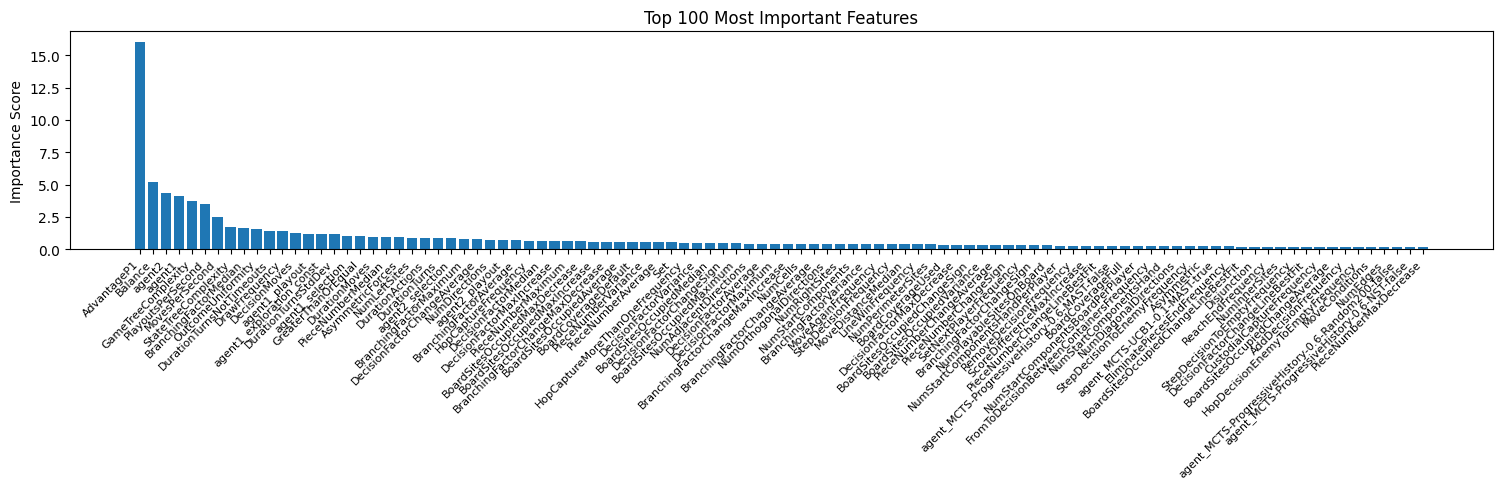

Fold 4 - RMSE: 0.4339377012261077
Fold 5


0:	learn: 0.6055751	test: 0.5837839	best: 0.5837839 (0)	total: 70.3ms	remaining: 3m 30s


50:	learn: 0.3831193	test: 0.4785536	best: 0.4785536 (50)	total: 4.22s	remaining: 4m 3s


100:	learn: 0.3455462	test: 0.4603588	best: 0.4603588 (100)	total: 8.61s	remaining: 4m 7s


150:	learn: 0.3242580	test: 0.4526472	best: 0.4524661 (149)	total: 13s	remaining: 4m 5s


200:	learn: 0.3087697	test: 0.4491334	best: 0.4491334 (200)	total: 17.6s	remaining: 4m 4s


250:	learn: 0.2973898	test: 0.4469169	best: 0.4468911 (248)	total: 22.1s	remaining: 4m 1s


300:	learn: 0.2879530	test: 0.4447072	best: 0.4447072 (300)	total: 26.5s	remaining: 3m 57s


350:	learn: 0.2800248	test: 0.4434433	best: 0.4434433 (350)	total: 30.8s	remaining: 3m 52s


400:	learn: 0.2729432	test: 0.4420846	best: 0.4420846 (400)	total: 35.2s	remaining: 3m 48s


450:	learn: 0.2669784	test: 0.4410862	best: 0.4410862 (450)	total: 39.7s	remaining: 3m 44s


500:	learn: 0.2612036	test: 0.4398910	best: 0.4398910 (500)	total: 44.1s	remaining: 3m 39s


550:	learn: 0.2564586	test: 0.4392210	best: 0.4391887 (545)	total: 48.5s	remaining: 3m 35s


600:	learn: 0.2517925	test: 0.4380384	best: 0.4380384 (600)	total: 52.9s	remaining: 3m 31s


650:	learn: 0.2478184	test: 0.4377202	best: 0.4377202 (650)	total: 57.3s	remaining: 3m 26s


700:	learn: 0.2435261	test: 0.4371643	best: 0.4371643 (700)	total: 1m 1s	remaining: 3m 22s


750:	learn: 0.2400316	test: 0.4368398	best: 0.4368206 (746)	total: 1m 6s	remaining: 3m 18s


800:	learn: 0.2369069	test: 0.4367122	best: 0.4365950 (788)	total: 1m 10s	remaining: 3m 13s


850:	learn: 0.2337209	test: 0.4365280	best: 0.4365103 (849)	total: 1m 15s	remaining: 3m 9s


900:	learn: 0.2309465	test: 0.4363347	best: 0.4363343 (894)	total: 1m 19s	remaining: 3m 5s


950:	learn: 0.2282501	test: 0.4360850	best: 0.4360850 (950)	total: 1m 24s	remaining: 3m 1s


1000:	learn: 0.2257108	test: 0.4359717	best: 0.4359627 (997)	total: 1m 28s	remaining: 2m 56s


1050:	learn: 0.2231855	test: 0.4357708	best: 0.4357300 (1045)	total: 1m 33s	remaining: 2m 52s


1100:	learn: 0.2210279	test: 0.4354879	best: 0.4354685 (1098)	total: 1m 37s	remaining: 2m 48s


1150:	learn: 0.2187984	test: 0.4353011	best: 0.4352698 (1124)	total: 1m 42s	remaining: 2m 43s


1200:	learn: 0.2165501	test: 0.4351404	best: 0.4351309 (1199)	total: 1m 46s	remaining: 2m 39s


1250:	learn: 0.2145156	test: 0.4349278	best: 0.4349200 (1245)	total: 1m 51s	remaining: 2m 35s


1300:	learn: 0.2124335	test: 0.4346601	best: 0.4346601 (1300)	total: 1m 55s	remaining: 2m 31s


1350:	learn: 0.2106121	test: 0.4346758	best: 0.4346478 (1306)	total: 2m	remaining: 2m 26s


1400:	learn: 0.2087299	test: 0.4345964	best: 0.4345765 (1397)	total: 2m 4s	remaining: 2m 22s


1450:	learn: 0.2068787	test: 0.4345761	best: 0.4345276 (1423)	total: 2m 9s	remaining: 2m 17s


1500:	learn: 0.2052347	test: 0.4345459	best: 0.4345276 (1423)	total: 2m 13s	remaining: 2m 13s


1550:	learn: 0.2035549	test: 0.4345409	best: 0.4345113 (1512)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2019828	test: 0.4344442	best: 0.4344252 (1599)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.2002558	test: 0.4344191	best: 0.4344090 (1644)	total: 2m 27s	remaining: 2m


1700:	learn: 0.1986947	test: 0.4343233	best: 0.4342996 (1683)	total: 2m 31s	remaining: 1m 55s


1750:	learn: 0.1971998	test: 0.4341855	best: 0.4341554 (1746)	total: 2m 36s	remaining: 1m 51s


1800:	learn: 0.1956698	test: 0.4341763	best: 0.4341129 (1786)	total: 2m 40s	remaining: 1m 46s


1850:	learn: 0.1941283	test: 0.4341113	best: 0.4341074 (1834)	total: 2m 45s	remaining: 1m 42s


1900:	learn: 0.1926365	test: 0.4340316	best: 0.4340316 (1900)	total: 2m 49s	remaining: 1m 38s


1950:	learn: 0.1912066	test: 0.4340114	best: 0.4339984 (1929)	total: 2m 54s	remaining: 1m 33s


2000:	learn: 0.1898088	test: 0.4340599	best: 0.4339729 (1959)	total: 2m 58s	remaining: 1m 29s


2050:	learn: 0.1884152	test: 0.4340113	best: 0.4339729 (1959)	total: 3m 3s	remaining: 1m 24s


2100:	learn: 0.1870172	test: 0.4340615	best: 0.4339729 (1959)	total: 3m 7s	remaining: 1m 20s


2150:	learn: 0.1856611	test: 0.4340189	best: 0.4339729 (1959)	total: 3m 12s	remaining: 1m 15s


2200:	learn: 0.1843411	test: 0.4339793	best: 0.4339617 (2191)	total: 3m 16s	remaining: 1m 11s


2250:	learn: 0.1830403	test: 0.4340171	best: 0.4339617 (2191)	total: 3m 21s	remaining: 1m 6s


2300:	learn: 0.1817157	test: 0.4339274	best: 0.4339154 (2294)	total: 3m 25s	remaining: 1m 2s


2350:	learn: 0.1804328	test: 0.4339374	best: 0.4339154 (2294)	total: 3m 30s	remaining: 58.1s


2400:	learn: 0.1792286	test: 0.4338613	best: 0.4338568 (2399)	total: 3m 34s	remaining: 53.6s


2450:	learn: 0.1780533	test: 0.4338832	best: 0.4338316 (2428)	total: 3m 39s	remaining: 49.1s


2500:	learn: 0.1769677	test: 0.4338397	best: 0.4338316 (2428)	total: 3m 43s	remaining: 44.7s


2550:	learn: 0.1756236	test: 0.4338424	best: 0.4338160 (2537)	total: 3m 48s	remaining: 40.2s


2600:	learn: 0.1744882	test: 0.4338204	best: 0.4337962 (2569)	total: 3m 52s	remaining: 35.7s


2650:	learn: 0.1733826	test: 0.4338026	best: 0.4337962 (2569)	total: 3m 57s	remaining: 31.3s


2700:	learn: 0.1723016	test: 0.4338272	best: 0.4337962 (2569)	total: 4m 2s	remaining: 26.8s


2750:	learn: 0.1710996	test: 0.4338120	best: 0.4337962 (2569)	total: 4m 6s	remaining: 22.3s


2800:	learn: 0.1699926	test: 0.4337523	best: 0.4337326 (2780)	total: 4m 11s	remaining: 17.8s


2850:	learn: 0.1687885	test: 0.4337290	best: 0.4337115 (2829)	total: 4m 15s	remaining: 13.4s


2900:	learn: 0.1677780	test: 0.4337316	best: 0.4337074 (2894)	total: 4m 20s	remaining: 8.88s


2950:	learn: 0.1667927	test: 0.4337215	best: 0.4337022 (2925)	total: 4m 24s	remaining: 4.39s


2999:	learn: 0.1658719	test: 0.4336853	best: 0.4336853 (2999)	total: 4m 29s	remaining: 0us

bestTest = 0.4336852791
bestIteration = 2999



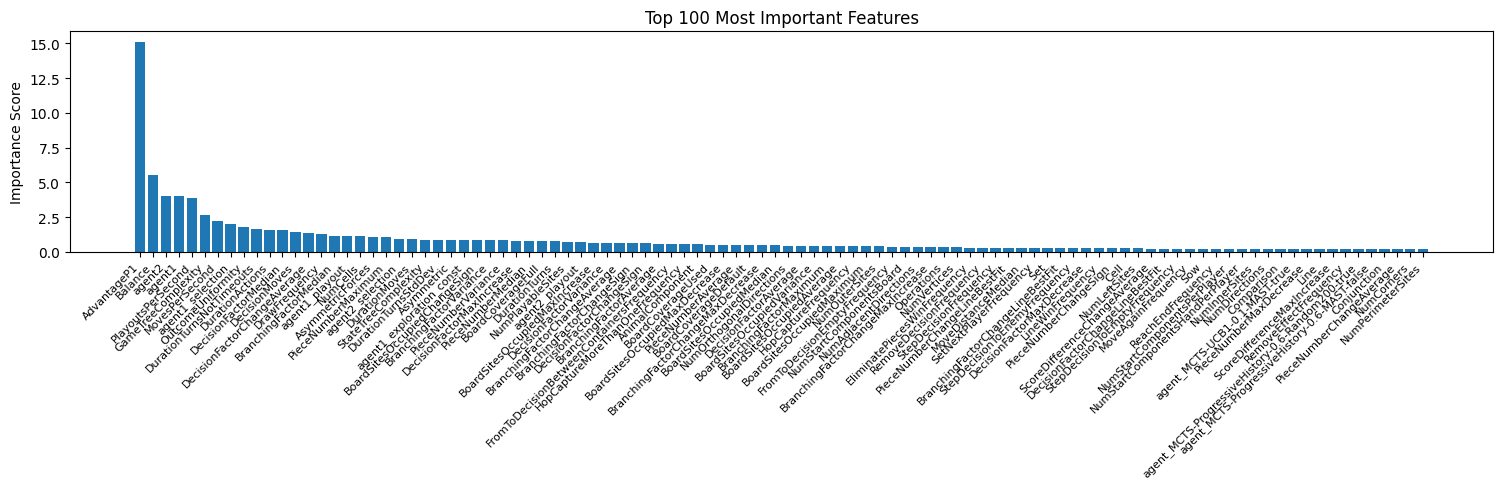

Fold 5 - RMSE: 0.43285253450322747
List of oof scores: [0.4060771588058601, 0.3950845574692823, 0.42838373937284363, 0.4339377012261077, 0.43285253450322747]
Average oof score: 0.4192671382754642


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6072507	test: 0.5686691	best: 0.5686691 (0)	total: 74.2ms	remaining: 3m 42s


50:	learn: 0.3879688	test: 0.4721797	best: 0.4721797 (50)	total: 4.42s	remaining: 4m 15s


100:	learn: 0.3493090	test: 0.4566992	best: 0.4566992 (100)	total: 8.95s	remaining: 4m 16s


150:	learn: 0.3257871	test: 0.4505689	best: 0.4505689 (150)	total: 13.4s	remaining: 4m 13s


200:	learn: 0.3106625	test: 0.4470088	best: 0.4470088 (200)	total: 17.8s	remaining: 4m 8s


250:	learn: 0.2994707	test: 0.4448049	best: 0.4446803 (245)	total: 22.3s	remaining: 4m 4s


300:	learn: 0.2900720	test: 0.4430402	best: 0.4430402 (300)	total: 26.8s	remaining: 4m


350:	learn: 0.2823071	test: 0.4417166	best: 0.4417166 (350)	total: 31.2s	remaining: 3m 55s


400:	learn: 0.2747334	test: 0.4406659	best: 0.4405881 (397)	total: 35.7s	remaining: 3m 51s


450:	learn: 0.2684006	test: 0.4398074	best: 0.4398074 (450)	total: 40.2s	remaining: 3m 47s


500:	learn: 0.2624396	test: 0.4386653	best: 0.4386653 (500)	total: 44.8s	remaining: 3m 43s


550:	learn: 0.2571518	test: 0.4377782	best: 0.4377170 (546)	total: 49.2s	remaining: 3m 38s


600:	learn: 0.2531563	test: 0.4373748	best: 0.4373240 (599)	total: 53.7s	remaining: 3m 34s


650:	learn: 0.2490514	test: 0.4369429	best: 0.4369429 (650)	total: 58.3s	remaining: 3m 30s


700:	learn: 0.2448024	test: 0.4365127	best: 0.4365012 (696)	total: 1m 2s	remaining: 3m 26s


750:	learn: 0.2413135	test: 0.4359875	best: 0.4359875 (750)	total: 1m 7s	remaining: 3m 21s


800:	learn: 0.2377723	test: 0.4357178	best: 0.4357163 (798)	total: 1m 11s	remaining: 3m 17s


850:	learn: 0.2347077	test: 0.4354066	best: 0.4353664 (843)	total: 1m 16s	remaining: 3m 12s


900:	learn: 0.2315724	test: 0.4351769	best: 0.4351769 (900)	total: 1m 20s	remaining: 3m 8s


950:	learn: 0.2288618	test: 0.4351716	best: 0.4351342 (948)	total: 1m 25s	remaining: 3m 3s


1000:	learn: 0.2264313	test: 0.4350973	best: 0.4350740 (994)	total: 1m 29s	remaining: 2m 59s


1050:	learn: 0.2239063	test: 0.4349994	best: 0.4349668 (1047)	total: 1m 34s	remaining: 2m 55s


1100:	learn: 0.2213889	test: 0.4348725	best: 0.4348655 (1095)	total: 1m 38s	remaining: 2m 50s


1150:	learn: 0.2191809	test: 0.4346864	best: 0.4346697 (1142)	total: 1m 43s	remaining: 2m 46s


1200:	learn: 0.2170359	test: 0.4345636	best: 0.4345253 (1197)	total: 1m 48s	remaining: 2m 41s


1250:	learn: 0.2146510	test: 0.4346101	best: 0.4345253 (1197)	total: 1m 52s	remaining: 2m 37s


1300:	learn: 0.2125861	test: 0.4344589	best: 0.4344589 (1300)	total: 1m 57s	remaining: 2m 32s


1350:	learn: 0.2107042	test: 0.4343768	best: 0.4343495 (1330)	total: 2m 1s	remaining: 2m 28s


1400:	learn: 0.2089170	test: 0.4342758	best: 0.4342648 (1389)	total: 2m 6s	remaining: 2m 24s


1450:	learn: 0.2071203	test: 0.4342611	best: 0.4342237 (1444)	total: 2m 10s	remaining: 2m 19s


1500:	learn: 0.2054451	test: 0.4341068	best: 0.4341068 (1500)	total: 2m 15s	remaining: 2m 15s


1550:	learn: 0.2037395	test: 0.4340810	best: 0.4340764 (1529)	total: 2m 19s	remaining: 2m 10s


1600:	learn: 0.2019631	test: 0.4340935	best: 0.4340483 (1578)	total: 2m 24s	remaining: 2m 6s


1650:	learn: 0.2003999	test: 0.4340812	best: 0.4340054 (1635)	total: 2m 28s	remaining: 2m 1s


1700:	learn: 0.1988403	test: 0.4341007	best: 0.4340054 (1635)	total: 2m 33s	remaining: 1m 57s


1750:	learn: 0.1972664	test: 0.4341023	best: 0.4340054 (1635)	total: 2m 37s	remaining: 1m 52s


1800:	learn: 0.1958034	test: 0.4342118	best: 0.4340054 (1635)	total: 2m 42s	remaining: 1m 48s


1850:	learn: 0.1944255	test: 0.4342089	best: 0.4340054 (1635)	total: 2m 47s	remaining: 1m 43s


1900:	learn: 0.1929596	test: 0.4341822	best: 0.4340054 (1635)	total: 2m 51s	remaining: 1m 39s


1950:	learn: 0.1916323	test: 0.4341565	best: 0.4340054 (1635)	total: 2m 56s	remaining: 1m 34s


2000:	learn: 0.1902102	test: 0.4341516	best: 0.4340054 (1635)	total: 3m	remaining: 1m 30s


2050:	learn: 0.1888251	test: 0.4341393	best: 0.4340054 (1635)	total: 3m 5s	remaining: 1m 25s


2100:	learn: 0.1874882	test: 0.4342036	best: 0.4340054 (1635)	total: 3m 10s	remaining: 1m 21s


2150:	learn: 0.1860884	test: 0.4342261	best: 0.4340054 (1635)	total: 3m 14s	remaining: 1m 16s


2200:	learn: 0.1847804	test: 0.4342063	best: 0.4340054 (1635)	total: 3m 19s	remaining: 1m 12s


2250:	learn: 0.1834487	test: 0.4342350	best: 0.4340054 (1635)	total: 3m 23s	remaining: 1m 7s


2300:	learn: 0.1821957	test: 0.4341481	best: 0.4340054 (1635)	total: 3m 28s	remaining: 1m 3s


2350:	learn: 0.1810556	test: 0.4340796	best: 0.4340054 (1635)	total: 3m 33s	remaining: 58.8s


2400:	learn: 0.1798410	test: 0.4340767	best: 0.4340054 (1635)	total: 3m 37s	remaining: 54.3s


2450:	learn: 0.1786273	test: 0.4340744	best: 0.4340054 (1635)	total: 3m 42s	remaining: 49.8s


2500:	learn: 0.1774890	test: 0.4340780	best: 0.4340054 (1635)	total: 3m 46s	remaining: 45.3s


2550:	learn: 0.1762330	test: 0.4340328	best: 0.4340054 (1635)	total: 3m 51s	remaining: 40.7s


2600:	learn: 0.1752231	test: 0.4340060	best: 0.4339593 (2569)	total: 3m 56s	remaining: 36.2s


2650:	learn: 0.1740966	test: 0.4339866	best: 0.4339593 (2569)	total: 4m	remaining: 31.7s


2700:	learn: 0.1730598	test: 0.4340110	best: 0.4339593 (2569)	total: 4m 5s	remaining: 27.1s


2750:	learn: 0.1718607	test: 0.4340341	best: 0.4339593 (2569)	total: 4m 9s	remaining: 22.6s


2800:	learn: 0.1707639	test: 0.4340736	best: 0.4339593 (2569)	total: 4m 14s	remaining: 18.1s


2850:	learn: 0.1697380	test: 0.4341022	best: 0.4339593 (2569)	total: 4m 18s	remaining: 13.5s


2900:	learn: 0.1686103	test: 0.4341020	best: 0.4339593 (2569)	total: 4m 23s	remaining: 8.99s


2950:	learn: 0.1675632	test: 0.4340776	best: 0.4339593 (2569)	total: 4m 27s	remaining: 4.45s


2999:	learn: 0.1665763	test: 0.4340975	best: 0.4339593 (2569)	total: 4m 32s	remaining: 0us

bestTest = 0.433959342
bestIteration = 2569

Shrink model to first 2570 iterations.


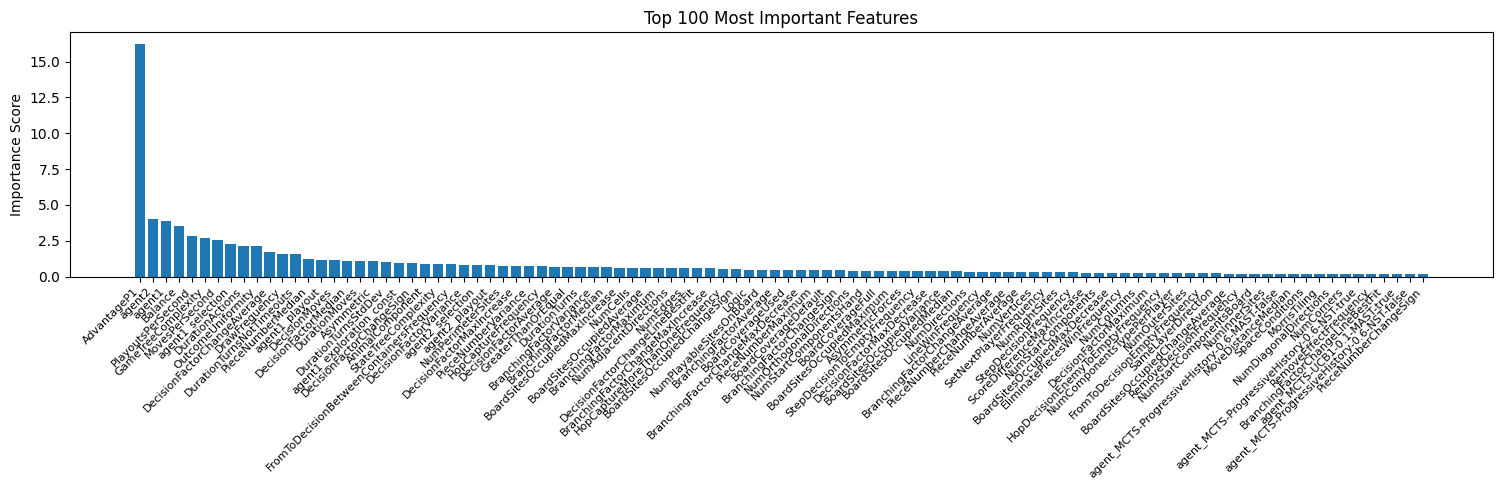

Fold 1 - RMSE: 0.43332775375853033
Fold 2


0:	learn: 0.6079185	test: 0.5699211	best: 0.5699211 (0)	total: 81.3ms	remaining: 4m 3s


50:	learn: 0.3881495	test: 0.4644026	best: 0.4644026 (50)	total: 4.43s	remaining: 4m 16s


100:	learn: 0.3485526	test: 0.4446942	best: 0.4446942 (100)	total: 9.09s	remaining: 4m 20s


150:	learn: 0.3253731	test: 0.4370619	best: 0.4370619 (150)	total: 13.7s	remaining: 4m 17s


200:	learn: 0.3105864	test: 0.4321583	best: 0.4321583 (200)	total: 18.2s	remaining: 4m 13s


250:	learn: 0.3001700	test: 0.4291874	best: 0.4291874 (250)	total: 22.7s	remaining: 4m 8s


300:	learn: 0.2906697	test: 0.4267236	best: 0.4267108 (298)	total: 27.2s	remaining: 4m 3s


350:	learn: 0.2823714	test: 0.4239626	best: 0.4239626 (350)	total: 31.7s	remaining: 3m 59s


400:	learn: 0.2748486	test: 0.4226868	best: 0.4226868 (400)	total: 36.1s	remaining: 3m 54s


450:	learn: 0.2690892	test: 0.4219135	best: 0.4219135 (450)	total: 40.7s	remaining: 3m 50s


500:	learn: 0.2628373	test: 0.4211887	best: 0.4211833 (498)	total: 45.1s	remaining: 3m 45s


550:	learn: 0.2578281	test: 0.4204560	best: 0.4204366 (546)	total: 49.7s	remaining: 3m 40s


600:	learn: 0.2532941	test: 0.4197411	best: 0.4197167 (598)	total: 54.2s	remaining: 3m 36s


650:	learn: 0.2492260	test: 0.4195571	best: 0.4195454 (649)	total: 58.7s	remaining: 3m 31s


700:	learn: 0.2451725	test: 0.4189568	best: 0.4189568 (700)	total: 1m 3s	remaining: 3m 27s


750:	learn: 0.2415347	test: 0.4185535	best: 0.4185101 (747)	total: 1m 7s	remaining: 3m 22s


800:	learn: 0.2382870	test: 0.4182293	best: 0.4182293 (800)	total: 1m 12s	remaining: 3m 18s


850:	learn: 0.2351363	test: 0.4180640	best: 0.4180600 (849)	total: 1m 16s	remaining: 3m 13s


900:	learn: 0.2324193	test: 0.4176398	best: 0.4176398 (900)	total: 1m 21s	remaining: 3m 9s


950:	learn: 0.2295996	test: 0.4174161	best: 0.4174161 (950)	total: 1m 25s	remaining: 3m 4s


1000:	learn: 0.2270774	test: 0.4173169	best: 0.4172724 (993)	total: 1m 30s	remaining: 3m


1050:	learn: 0.2247079	test: 0.4170502	best: 0.4170502 (1050)	total: 1m 34s	remaining: 2m 56s


1100:	learn: 0.2221409	test: 0.4169190	best: 0.4169139 (1097)	total: 1m 39s	remaining: 2m 51s


1150:	learn: 0.2198205	test: 0.4167457	best: 0.4167323 (1139)	total: 1m 43s	remaining: 2m 46s


1200:	learn: 0.2175432	test: 0.4165302	best: 0.4165132 (1195)	total: 1m 48s	remaining: 2m 42s


1250:	learn: 0.2155592	test: 0.4164406	best: 0.4164406 (1250)	total: 1m 52s	remaining: 2m 37s


1300:	learn: 0.2135167	test: 0.4162641	best: 0.4162525 (1295)	total: 1m 57s	remaining: 2m 33s


1350:	learn: 0.2117027	test: 0.4161786	best: 0.4161786 (1350)	total: 2m 2s	remaining: 2m 29s


1400:	learn: 0.2097692	test: 0.4160885	best: 0.4160885 (1400)	total: 2m 6s	remaining: 2m 24s


1450:	learn: 0.2079825	test: 0.4160232	best: 0.4160228 (1448)	total: 2m 11s	remaining: 2m 20s


1500:	learn: 0.2062456	test: 0.4159750	best: 0.4159179 (1473)	total: 2m 15s	remaining: 2m 15s


1550:	learn: 0.2045498	test: 0.4159119	best: 0.4158986 (1541)	total: 2m 20s	remaining: 2m 11s


1600:	learn: 0.2028909	test: 0.4159469	best: 0.4158930 (1553)	total: 2m 25s	remaining: 2m 6s


1650:	learn: 0.2012069	test: 0.4159117	best: 0.4158930 (1553)	total: 2m 29s	remaining: 2m 2s


1700:	learn: 0.1996245	test: 0.4158468	best: 0.4158285 (1697)	total: 2m 34s	remaining: 1m 57s


1750:	learn: 0.1980593	test: 0.4157655	best: 0.4157651 (1749)	total: 2m 38s	remaining: 1m 53s


1800:	learn: 0.1967172	test: 0.4157698	best: 0.4157598 (1795)	total: 2m 43s	remaining: 1m 48s


1850:	learn: 0.1952550	test: 0.4157347	best: 0.4157291 (1846)	total: 2m 47s	remaining: 1m 44s


1900:	learn: 0.1938154	test: 0.4157142	best: 0.4156555 (1891)	total: 2m 52s	remaining: 1m 39s


1950:	learn: 0.1925515	test: 0.4157644	best: 0.4156555 (1891)	total: 2m 57s	remaining: 1m 35s


2000:	learn: 0.1911109	test: 0.4156768	best: 0.4156555 (1891)	total: 3m 1s	remaining: 1m 30s


2050:	learn: 0.1897725	test: 0.4155823	best: 0.4155448 (2035)	total: 3m 6s	remaining: 1m 26s


2100:	learn: 0.1883918	test: 0.4155940	best: 0.4155448 (2035)	total: 3m 10s	remaining: 1m 21s


2150:	learn: 0.1871079	test: 0.4156216	best: 0.4155448 (2035)	total: 3m 15s	remaining: 1m 17s


2200:	learn: 0.1858640	test: 0.4155770	best: 0.4155448 (2035)	total: 3m 19s	remaining: 1m 12s


2250:	learn: 0.1845676	test: 0.4155654	best: 0.4155448 (2035)	total: 3m 24s	remaining: 1m 8s


2300:	learn: 0.1832679	test: 0.4155545	best: 0.4155448 (2035)	total: 3m 29s	remaining: 1m 3s


2350:	learn: 0.1819329	test: 0.4155091	best: 0.4154987 (2345)	total: 3m 33s	remaining: 59s


2400:	learn: 0.1806543	test: 0.4155263	best: 0.4154987 (2345)	total: 3m 38s	remaining: 54.4s


2450:	learn: 0.1793950	test: 0.4154333	best: 0.4154304 (2449)	total: 3m 42s	remaining: 49.9s


2500:	learn: 0.1781983	test: 0.4153331	best: 0.4153210 (2488)	total: 3m 47s	remaining: 45.3s


2550:	learn: 0.1769639	test: 0.4152888	best: 0.4152841 (2543)	total: 3m 51s	remaining: 40.8s


2600:	learn: 0.1757775	test: 0.4151699	best: 0.4151661 (2598)	total: 3m 56s	remaining: 36.3s


2650:	learn: 0.1747048	test: 0.4151287	best: 0.4151272 (2648)	total: 4m	remaining: 31.7s


2700:	learn: 0.1735315	test: 0.4150524	best: 0.4150430 (2695)	total: 4m 5s	remaining: 27.2s


2750:	learn: 0.1724736	test: 0.4149859	best: 0.4149816 (2747)	total: 4m 10s	remaining: 22.6s


2800:	learn: 0.1713411	test: 0.4149795	best: 0.4149408 (2763)	total: 4m 14s	remaining: 18.1s


2850:	learn: 0.1702611	test: 0.4148958	best: 0.4148958 (2850)	total: 4m 19s	remaining: 13.6s


2900:	learn: 0.1691980	test: 0.4148601	best: 0.4148540 (2883)	total: 4m 23s	remaining: 9.01s


2950:	learn: 0.1682127	test: 0.4148774	best: 0.4148295 (2918)	total: 4m 28s	remaining: 4.46s


2999:	learn: 0.1672240	test: 0.4148602	best: 0.4148295 (2918)	total: 4m 32s	remaining: 0us

bestTest = 0.4148294578
bestIteration = 2918

Shrink model to first 2919 iterations.


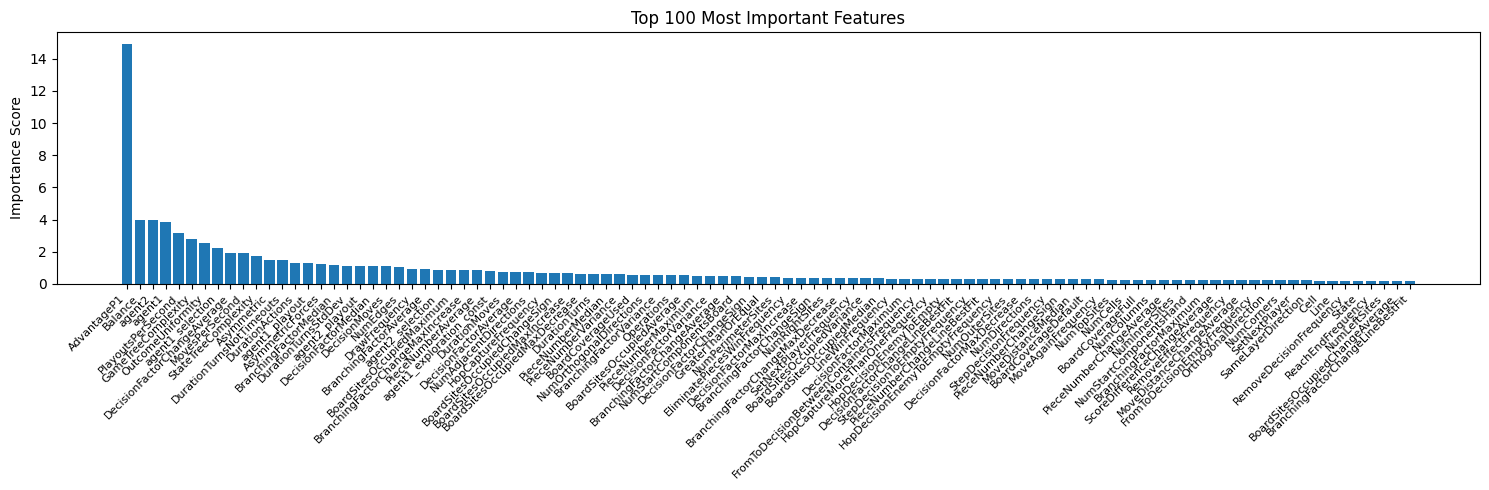

Fold 2 - RMSE: 0.41437222765706977
Fold 3


0:	learn: 0.6108606	test: 0.5690059	best: 0.5690059 (0)	total: 72ms	remaining: 3m 36s


50:	learn: 0.3878745	test: 0.4615561	best: 0.4615561 (50)	total: 4.17s	remaining: 4m 1s


100:	learn: 0.3469493	test: 0.4456911	best: 0.4456911 (100)	total: 8.52s	remaining: 4m 4s


150:	learn: 0.3235969	test: 0.4389273	best: 0.4389273 (150)	total: 12.8s	remaining: 4m 1s


200:	learn: 0.3086031	test: 0.4348926	best: 0.4348747 (199)	total: 17.1s	remaining: 3m 58s


250:	learn: 0.2969851	test: 0.4318137	best: 0.4318137 (250)	total: 21.4s	remaining: 3m 54s


300:	learn: 0.2876950	test: 0.4301066	best: 0.4301066 (300)	total: 25.7s	remaining: 3m 50s


350:	learn: 0.2796600	test: 0.4286336	best: 0.4286336 (350)	total: 30.1s	remaining: 3m 47s


400:	learn: 0.2728540	test: 0.4280200	best: 0.4278191 (380)	total: 34.4s	remaining: 3m 43s


450:	learn: 0.2664735	test: 0.4270370	best: 0.4270358 (449)	total: 38.7s	remaining: 3m 38s


500:	learn: 0.2608595	test: 0.4268236	best: 0.4267770 (476)	total: 43s	remaining: 3m 34s


550:	learn: 0.2558530	test: 0.4258668	best: 0.4258668 (550)	total: 47.4s	remaining: 3m 30s


600:	learn: 0.2513759	test: 0.4250874	best: 0.4250874 (600)	total: 51.7s	remaining: 3m 26s


650:	learn: 0.2469549	test: 0.4247192	best: 0.4247107 (638)	total: 56.1s	remaining: 3m 22s


700:	learn: 0.2432545	test: 0.4243893	best: 0.4243893 (700)	total: 1m	remaining: 3m 18s


750:	learn: 0.2398780	test: 0.4241482	best: 0.4241288 (748)	total: 1m 4s	remaining: 3m 14s


800:	learn: 0.2365463	test: 0.4240770	best: 0.4240770 (800)	total: 1m 9s	remaining: 3m 9s


850:	learn: 0.2334859	test: 0.4235373	best: 0.4235373 (850)	total: 1m 13s	remaining: 3m 5s


900:	learn: 0.2304028	test: 0.4232128	best: 0.4232128 (900)	total: 1m 17s	remaining: 3m 1s


950:	learn: 0.2275268	test: 0.4228409	best: 0.4228409 (950)	total: 1m 22s	remaining: 2m 56s


1000:	learn: 0.2249671	test: 0.4224496	best: 0.4224358 (999)	total: 1m 26s	remaining: 2m 52s


1050:	learn: 0.2223664	test: 0.4222026	best: 0.4222026 (1050)	total: 1m 30s	remaining: 2m 48s


1100:	learn: 0.2201336	test: 0.4219252	best: 0.4219191 (1095)	total: 1m 35s	remaining: 2m 44s


1150:	learn: 0.2177984	test: 0.4217965	best: 0.4217965 (1150)	total: 1m 39s	remaining: 2m 40s


1200:	learn: 0.2155575	test: 0.4215946	best: 0.4215878 (1198)	total: 1m 44s	remaining: 2m 35s


1250:	learn: 0.2133622	test: 0.4215727	best: 0.4215521 (1247)	total: 1m 48s	remaining: 2m 31s


1300:	learn: 0.2111065	test: 0.4215393	best: 0.4215073 (1257)	total: 1m 52s	remaining: 2m 27s


1350:	learn: 0.2091216	test: 0.4215768	best: 0.4215073 (1257)	total: 1m 57s	remaining: 2m 23s


1400:	learn: 0.2070597	test: 0.4215309	best: 0.4215073 (1257)	total: 2m 1s	remaining: 2m 18s


1450:	learn: 0.2052722	test: 0.4214242	best: 0.4214176 (1448)	total: 2m 6s	remaining: 2m 14s


1500:	learn: 0.2034757	test: 0.4212815	best: 0.4212815 (1500)	total: 2m 10s	remaining: 2m 10s


1550:	learn: 0.2016572	test: 0.4212044	best: 0.4211481 (1542)	total: 2m 14s	remaining: 2m 6s


1600:	learn: 0.1997509	test: 0.4211588	best: 0.4211404 (1598)	total: 2m 19s	remaining: 2m 1s


1650:	learn: 0.1980040	test: 0.4211226	best: 0.4210944 (1635)	total: 2m 23s	remaining: 1m 57s


1700:	learn: 0.1963887	test: 0.4210600	best: 0.4210600 (1700)	total: 2m 28s	remaining: 1m 53s


1750:	learn: 0.1947785	test: 0.4210009	best: 0.4209852 (1748)	total: 2m 32s	remaining: 1m 48s


1800:	learn: 0.1933178	test: 0.4210178	best: 0.4209846 (1761)	total: 2m 37s	remaining: 1m 44s


1850:	learn: 0.1918115	test: 0.4209760	best: 0.4209435 (1836)	total: 2m 41s	remaining: 1m 40s


1900:	learn: 0.1902258	test: 0.4209325	best: 0.4209325 (1900)	total: 2m 45s	remaining: 1m 35s


1950:	learn: 0.1887441	test: 0.4209204	best: 0.4209204 (1950)	total: 2m 50s	remaining: 1m 31s


2000:	learn: 0.1872763	test: 0.4208881	best: 0.4208881 (1998)	total: 2m 54s	remaining: 1m 27s


2050:	learn: 0.1857746	test: 0.4209032	best: 0.4208881 (1998)	total: 2m 59s	remaining: 1m 22s


2100:	learn: 0.1843727	test: 0.4208960	best: 0.4208651 (2095)	total: 3m 3s	remaining: 1m 18s


2150:	learn: 0.1829586	test: 0.4208559	best: 0.4208416 (2145)	total: 3m 7s	remaining: 1m 14s


2200:	learn: 0.1815582	test: 0.4207535	best: 0.4207522 (2199)	total: 3m 12s	remaining: 1m 9s


2250:	learn: 0.1802004	test: 0.4206432	best: 0.4206432 (2250)	total: 3m 16s	remaining: 1m 5s


2300:	learn: 0.1788165	test: 0.4206193	best: 0.4205772 (2296)	total: 3m 21s	remaining: 1m 1s


2350:	learn: 0.1774875	test: 0.4205843	best: 0.4205772 (2296)	total: 3m 25s	remaining: 56.7s


2400:	learn: 0.1762277	test: 0.4205888	best: 0.4205436 (2381)	total: 3m 29s	remaining: 52.4s


2450:	learn: 0.1749393	test: 0.4205527	best: 0.4205298 (2447)	total: 3m 34s	remaining: 48s


2500:	learn: 0.1737393	test: 0.4204780	best: 0.4204780 (2500)	total: 3m 38s	remaining: 43.6s


2550:	learn: 0.1725764	test: 0.4203715	best: 0.4203663 (2549)	total: 3m 43s	remaining: 39.3s


2600:	learn: 0.1714108	test: 0.4203496	best: 0.4203425 (2563)	total: 3m 47s	remaining: 34.9s


2650:	learn: 0.1702840	test: 0.4203835	best: 0.4203425 (2563)	total: 3m 52s	remaining: 30.6s


2700:	learn: 0.1691660	test: 0.4204032	best: 0.4203425 (2563)	total: 3m 56s	remaining: 26.2s


2750:	learn: 0.1680845	test: 0.4203919	best: 0.4203425 (2563)	total: 4m 1s	remaining: 21.8s


2800:	learn: 0.1669826	test: 0.4204014	best: 0.4203425 (2563)	total: 4m 5s	remaining: 17.4s


2850:	learn: 0.1658385	test: 0.4204144	best: 0.4203425 (2563)	total: 4m 9s	remaining: 13.1s


2900:	learn: 0.1648627	test: 0.4203414	best: 0.4203267 (2894)	total: 4m 14s	remaining: 8.67s


2950:	learn: 0.1636803	test: 0.4203373	best: 0.4203267 (2894)	total: 4m 18s	remaining: 4.29s


2999:	learn: 0.1626453	test: 0.4203424	best: 0.4203055 (2971)	total: 4m 22s	remaining: 0us

bestTest = 0.4203054534
bestIteration = 2971

Shrink model to first 2972 iterations.


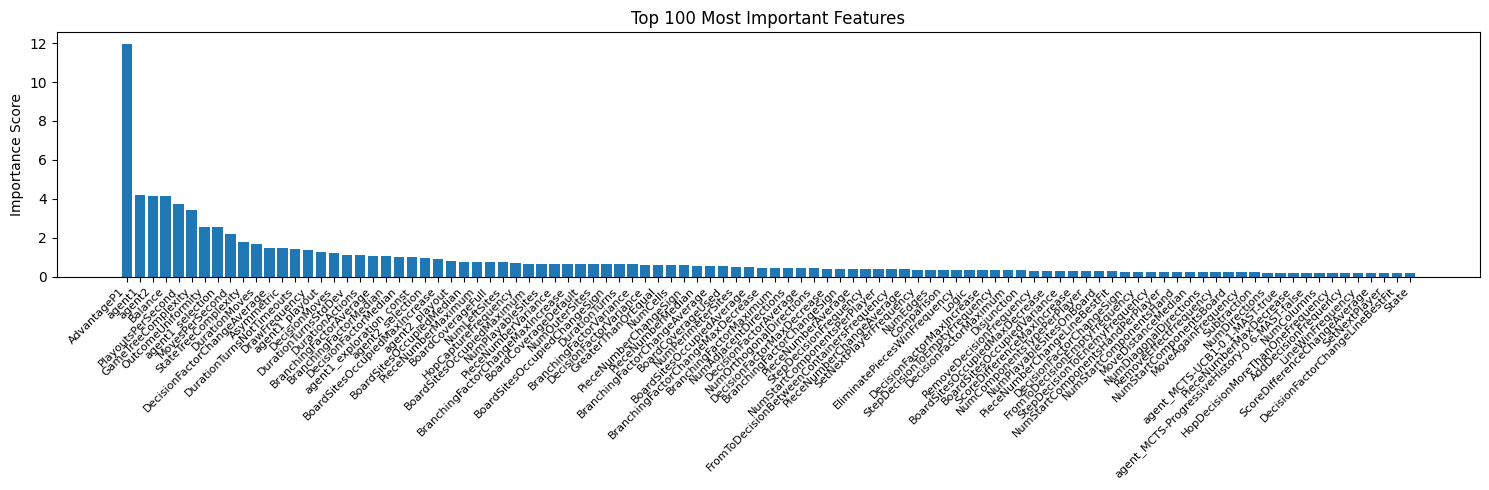

Fold 3 - RMSE: 0.41988228198840993
Fold 4


0:	learn: 0.6094902	test: 0.5656350	best: 0.5656350 (0)	total: 87.7ms	remaining: 4m 22s


50:	learn: 0.3892641	test: 0.4581125	best: 0.4581125 (50)	total: 4.23s	remaining: 4m 4s


100:	learn: 0.3485278	test: 0.4421691	best: 0.4421691 (100)	total: 8.66s	remaining: 4m 8s


150:	learn: 0.3258356	test: 0.4338644	best: 0.4338644 (150)	total: 13s	remaining: 4m 4s


200:	learn: 0.3103226	test: 0.4300996	best: 0.4300996 (200)	total: 17.3s	remaining: 4m


250:	learn: 0.2994247	test: 0.4273420	best: 0.4273420 (250)	total: 21.7s	remaining: 3m 57s


300:	learn: 0.2895179	test: 0.4254553	best: 0.4254553 (300)	total: 25.9s	remaining: 3m 52s


350:	learn: 0.2814860	test: 0.4237172	best: 0.4237172 (350)	total: 30.3s	remaining: 3m 48s


400:	learn: 0.2742849	test: 0.4226578	best: 0.4226578 (400)	total: 34.7s	remaining: 3m 45s


450:	learn: 0.2683610	test: 0.4215042	best: 0.4215042 (450)	total: 39.2s	remaining: 3m 41s


500:	learn: 0.2628542	test: 0.4206244	best: 0.4206220 (499)	total: 43.5s	remaining: 3m 36s


550:	learn: 0.2581163	test: 0.4201084	best: 0.4201084 (550)	total: 47.9s	remaining: 3m 33s


600:	learn: 0.2534526	test: 0.4192167	best: 0.4191984 (599)	total: 52.4s	remaining: 3m 28s


650:	learn: 0.2490531	test: 0.4187908	best: 0.4187908 (650)	total: 56.7s	remaining: 3m 24s


700:	learn: 0.2451989	test: 0.4184232	best: 0.4183870 (695)	total: 1m 1s	remaining: 3m 20s


750:	learn: 0.2416667	test: 0.4180233	best: 0.4180233 (750)	total: 1m 5s	remaining: 3m 16s


800:	learn: 0.2381213	test: 0.4176979	best: 0.4176196 (795)	total: 1m 9s	remaining: 3m 12s


850:	learn: 0.2348865	test: 0.4174408	best: 0.4174408 (850)	total: 1m 14s	remaining: 3m 7s


900:	learn: 0.2320112	test: 0.4173890	best: 0.4173440 (870)	total: 1m 18s	remaining: 3m 3s


950:	learn: 0.2293398	test: 0.4174536	best: 0.4173440 (870)	total: 1m 23s	remaining: 2m 59s


1000:	learn: 0.2268852	test: 0.4172424	best: 0.4172253 (999)	total: 1m 27s	remaining: 2m 54s


1050:	learn: 0.2243973	test: 0.4171079	best: 0.4171079 (1050)	total: 1m 32s	remaining: 2m 50s


1100:	learn: 0.2221120	test: 0.4171783	best: 0.4170697 (1083)	total: 1m 36s	remaining: 2m 46s


1150:	learn: 0.2198276	test: 0.4172168	best: 0.4170697 (1083)	total: 1m 40s	remaining: 2m 42s


1200:	learn: 0.2176582	test: 0.4171000	best: 0.4170466 (1189)	total: 1m 45s	remaining: 2m 37s


1250:	learn: 0.2155345	test: 0.4170953	best: 0.4169963 (1232)	total: 1m 49s	remaining: 2m 33s


1300:	learn: 0.2135183	test: 0.4170786	best: 0.4169963 (1232)	total: 1m 54s	remaining: 2m 29s


1350:	learn: 0.2115794	test: 0.4169689	best: 0.4169636 (1349)	total: 1m 58s	remaining: 2m 24s


1400:	learn: 0.2097463	test: 0.4168888	best: 0.4168692 (1396)	total: 2m 2s	remaining: 2m 20s


1450:	learn: 0.2078789	test: 0.4166887	best: 0.4166887 (1450)	total: 2m 7s	remaining: 2m 16s


1500:	learn: 0.2060128	test: 0.4165898	best: 0.4165677 (1484)	total: 2m 11s	remaining: 2m 11s


1550:	learn: 0.2043554	test: 0.4165390	best: 0.4165222 (1547)	total: 2m 16s	remaining: 2m 7s


1600:	learn: 0.2026364	test: 0.4165229	best: 0.4164969 (1593)	total: 2m 20s	remaining: 2m 2s


1650:	learn: 0.2012289	test: 0.4165212	best: 0.4164957 (1643)	total: 2m 25s	remaining: 1m 58s


1700:	learn: 0.1994952	test: 0.4165169	best: 0.4164654 (1683)	total: 2m 29s	remaining: 1m 54s


1750:	learn: 0.1980863	test: 0.4164956	best: 0.4164654 (1683)	total: 2m 34s	remaining: 1m 50s


1800:	learn: 0.1963609	test: 0.4165073	best: 0.4164470 (1771)	total: 2m 38s	remaining: 1m 45s


1850:	learn: 0.1947709	test: 0.4164297	best: 0.4164297 (1850)	total: 2m 43s	remaining: 1m 41s


1900:	learn: 0.1934036	test: 0.4164557	best: 0.4163929 (1881)	total: 2m 47s	remaining: 1m 36s


1950:	learn: 0.1917548	test: 0.4164336	best: 0.4163929 (1881)	total: 2m 52s	remaining: 1m 32s


2000:	learn: 0.1903403	test: 0.4163817	best: 0.4163755 (1999)	total: 2m 56s	remaining: 1m 28s


2050:	learn: 0.1889179	test: 0.4163865	best: 0.4163549 (2031)	total: 3m 1s	remaining: 1m 23s


2100:	learn: 0.1876263	test: 0.4163985	best: 0.4163549 (2031)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.1862636	test: 0.4163783	best: 0.4163549 (2031)	total: 3m 9s	remaining: 1m 14s


2200:	learn: 0.1849216	test: 0.4163784	best: 0.4163549 (2031)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.1836510	test: 0.4163800	best: 0.4163491 (2209)	total: 3m 18s	remaining: 1m 6s


2300:	learn: 0.1824545	test: 0.4163183	best: 0.4163118 (2297)	total: 3m 23s	remaining: 1m 1s


2350:	learn: 0.1810978	test: 0.4163287	best: 0.4162843 (2331)	total: 3m 27s	remaining: 57.4s


2400:	learn: 0.1799033	test: 0.4163431	best: 0.4162843 (2331)	total: 3m 32s	remaining: 53s


2450:	learn: 0.1785549	test: 0.4162253	best: 0.4162253 (2450)	total: 3m 36s	remaining: 48.5s


2500:	learn: 0.1771799	test: 0.4161759	best: 0.4161739 (2499)	total: 3m 41s	remaining: 44.1s


2550:	learn: 0.1759994	test: 0.4161905	best: 0.4161575 (2531)	total: 3m 45s	remaining: 39.7s


2600:	learn: 0.1746984	test: 0.4161234	best: 0.4160942 (2589)	total: 3m 50s	remaining: 35.3s


2650:	learn: 0.1735435	test: 0.4160469	best: 0.4160469 (2650)	total: 3m 54s	remaining: 30.9s


2700:	learn: 0.1724705	test: 0.4160742	best: 0.4160342 (2668)	total: 3m 59s	remaining: 26.5s


2750:	learn: 0.1713301	test: 0.4161934	best: 0.4160342 (2668)	total: 4m 3s	remaining: 22s


2800:	learn: 0.1701820	test: 0.4162259	best: 0.4160342 (2668)	total: 4m 8s	remaining: 17.6s


2850:	learn: 0.1691450	test: 0.4162280	best: 0.4160342 (2668)	total: 4m 12s	remaining: 13.2s


2900:	learn: 0.1680119	test: 0.4162140	best: 0.4160342 (2668)	total: 4m 16s	remaining: 8.77s


2950:	learn: 0.1669880	test: 0.4162113	best: 0.4160342 (2668)	total: 4m 21s	remaining: 4.34s


2999:	learn: 0.1658065	test: 0.4161689	best: 0.4160342 (2668)	total: 4m 25s	remaining: 0us

bestTest = 0.4160341782
bestIteration = 2668

Shrink model to first 2669 iterations.


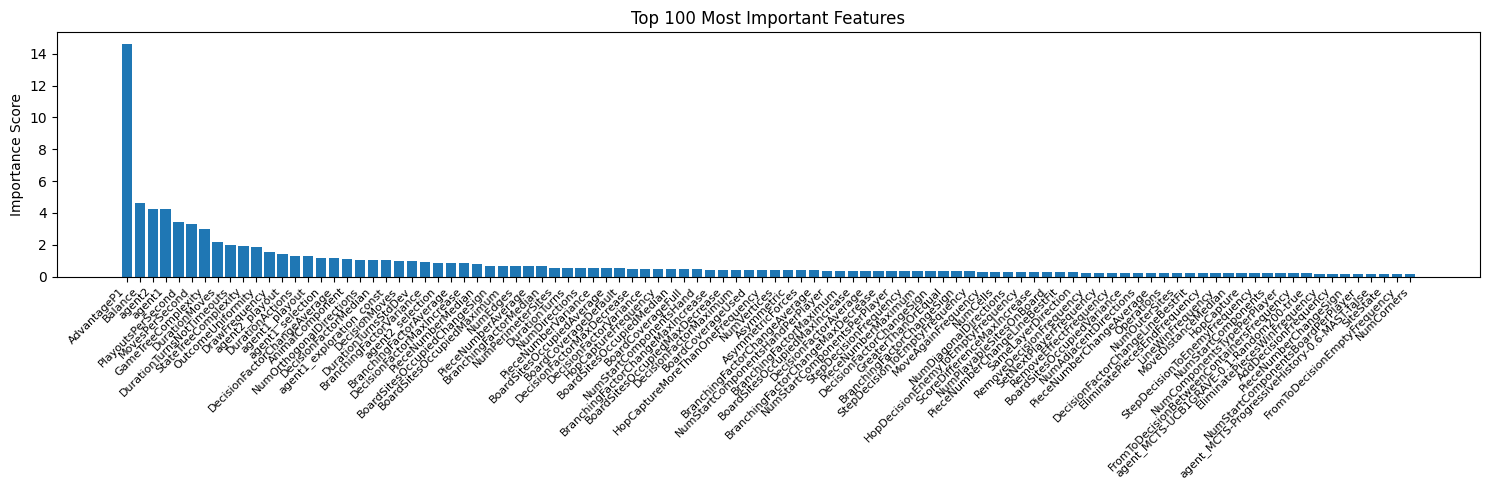

Fold 4 - RMSE: 0.4151951983161339
Fold 5


0:	learn: 0.6042032	test: 0.5801041	best: 0.5801041 (0)	total: 69.8ms	remaining: 3m 29s


50:	learn: 0.3879682	test: 0.4790189	best: 0.4790189 (50)	total: 4.31s	remaining: 4m 9s


100:	learn: 0.3474675	test: 0.4598515	best: 0.4598515 (100)	total: 8.98s	remaining: 4m 17s


150:	learn: 0.3250363	test: 0.4506283	best: 0.4506283 (150)	total: 13.4s	remaining: 4m 13s


200:	learn: 0.3092197	test: 0.4448066	best: 0.4448028 (199)	total: 17.9s	remaining: 4m 9s


250:	learn: 0.2988457	test: 0.4422424	best: 0.4422216 (249)	total: 22.4s	remaining: 4m 5s


300:	learn: 0.2893187	test: 0.4399855	best: 0.4399405 (298)	total: 27s	remaining: 4m 2s


350:	learn: 0.2814939	test: 0.4390649	best: 0.4390649 (350)	total: 31.5s	remaining: 3m 57s


400:	learn: 0.2750784	test: 0.4378950	best: 0.4378950 (400)	total: 36.1s	remaining: 3m 53s


450:	learn: 0.2692436	test: 0.4370087	best: 0.4369923 (449)	total: 40.7s	remaining: 3m 50s


500:	learn: 0.2638457	test: 0.4362575	best: 0.4362555 (498)	total: 45.2s	remaining: 3m 45s


550:	learn: 0.2588076	test: 0.4355332	best: 0.4355328 (549)	total: 49.8s	remaining: 3m 41s


600:	learn: 0.2544301	test: 0.4349733	best: 0.4349460 (597)	total: 54.3s	remaining: 3m 36s


650:	learn: 0.2500324	test: 0.4344282	best: 0.4344282 (650)	total: 58.8s	remaining: 3m 32s


700:	learn: 0.2458988	test: 0.4340104	best: 0.4339975 (687)	total: 1m 3s	remaining: 3m 27s


750:	learn: 0.2422476	test: 0.4338345	best: 0.4337782 (745)	total: 1m 7s	remaining: 3m 23s


800:	learn: 0.2388677	test: 0.4335869	best: 0.4335869 (800)	total: 1m 12s	remaining: 3m 19s


850:	learn: 0.2358571	test: 0.4335444	best: 0.4334855 (841)	total: 1m 17s	remaining: 3m 14s


900:	learn: 0.2331575	test: 0.4332422	best: 0.4332422 (900)	total: 1m 21s	remaining: 3m 10s


950:	learn: 0.2305781	test: 0.4330276	best: 0.4330276 (950)	total: 1m 26s	remaining: 3m 5s


1000:	learn: 0.2277494	test: 0.4326308	best: 0.4326214 (999)	total: 1m 30s	remaining: 3m 1s


1050:	learn: 0.2253155	test: 0.4325114	best: 0.4324818 (1049)	total: 1m 35s	remaining: 2m 57s


1100:	learn: 0.2228665	test: 0.4324005	best: 0.4324001 (1098)	total: 1m 40s	remaining: 2m 52s


1150:	learn: 0.2207378	test: 0.4323351	best: 0.4323185 (1146)	total: 1m 44s	remaining: 2m 48s


1200:	learn: 0.2182241	test: 0.4320891	best: 0.4320326 (1192)	total: 1m 49s	remaining: 2m 43s


1250:	learn: 0.2158870	test: 0.4319324	best: 0.4319324 (1250)	total: 1m 53s	remaining: 2m 39s


1300:	learn: 0.2137716	test: 0.4317414	best: 0.4317414 (1300)	total: 1m 58s	remaining: 2m 34s


1350:	learn: 0.2115933	test: 0.4315686	best: 0.4315570 (1349)	total: 2m 2s	remaining: 2m 30s


1400:	learn: 0.2096448	test: 0.4315570	best: 0.4314692 (1378)	total: 2m 7s	remaining: 2m 25s


1450:	learn: 0.2077988	test: 0.4316056	best: 0.4314692 (1378)	total: 2m 12s	remaining: 2m 21s


1500:	learn: 0.2059241	test: 0.4315983	best: 0.4314692 (1378)	total: 2m 16s	remaining: 2m 16s


1550:	learn: 0.2041308	test: 0.4316636	best: 0.4314692 (1378)	total: 2m 21s	remaining: 2m 11s


1600:	learn: 0.2024935	test: 0.4315619	best: 0.4314692 (1378)	total: 2m 25s	remaining: 2m 7s


1650:	learn: 0.2008374	test: 0.4315399	best: 0.4314692 (1378)	total: 2m 30s	remaining: 2m 2s


1700:	learn: 0.1993369	test: 0.4315099	best: 0.4314692 (1378)	total: 2m 35s	remaining: 1m 58s


1750:	learn: 0.1976699	test: 0.4314801	best: 0.4314605 (1742)	total: 2m 39s	remaining: 1m 53s


1800:	learn: 0.1961231	test: 0.4313818	best: 0.4313632 (1784)	total: 2m 44s	remaining: 1m 49s


1850:	learn: 0.1945336	test: 0.4313022	best: 0.4312955 (1841)	total: 2m 48s	remaining: 1m 44s


1900:	learn: 0.1929658	test: 0.4312013	best: 0.4311962 (1886)	total: 2m 53s	remaining: 1m 40s


1950:	learn: 0.1916669	test: 0.4311591	best: 0.4311463 (1945)	total: 2m 57s	remaining: 1m 35s


2000:	learn: 0.1902865	test: 0.4310767	best: 0.4310700 (1997)	total: 3m 2s	remaining: 1m 31s


2050:	learn: 0.1889640	test: 0.4310026	best: 0.4310026 (2050)	total: 3m 7s	remaining: 1m 26s


2100:	learn: 0.1875952	test: 0.4310117	best: 0.4309316 (2063)	total: 3m 11s	remaining: 1m 22s


2150:	learn: 0.1861376	test: 0.4309401	best: 0.4309316 (2063)	total: 3m 16s	remaining: 1m 17s


2200:	learn: 0.1847611	test: 0.4308983	best: 0.4308960 (2198)	total: 3m 20s	remaining: 1m 12s


2250:	learn: 0.1835019	test: 0.4308204	best: 0.4308204 (2250)	total: 3m 25s	remaining: 1m 8s


2300:	learn: 0.1821247	test: 0.4308424	best: 0.4308025 (2286)	total: 3m 30s	remaining: 1m 3s


2350:	learn: 0.1809423	test: 0.4308285	best: 0.4307959 (2342)	total: 3m 34s	remaining: 59.3s


2400:	learn: 0.1796273	test: 0.4307420	best: 0.4307356 (2379)	total: 3m 39s	remaining: 54.7s


2450:	learn: 0.1783579	test: 0.4307141	best: 0.4306883 (2428)	total: 3m 44s	remaining: 50.2s


2500:	learn: 0.1772106	test: 0.4307308	best: 0.4306883 (2428)	total: 3m 48s	remaining: 45.6s


2550:	learn: 0.1760748	test: 0.4306523	best: 0.4306467 (2546)	total: 3m 53s	remaining: 41.1s


2600:	learn: 0.1748462	test: 0.4305289	best: 0.4305251 (2594)	total: 3m 57s	remaining: 36.5s


2650:	learn: 0.1736292	test: 0.4305054	best: 0.4305041 (2647)	total: 4m 2s	remaining: 31.9s


2700:	learn: 0.1725345	test: 0.4304596	best: 0.4304596 (2700)	total: 4m 7s	remaining: 27.4s


2750:	learn: 0.1713696	test: 0.4304877	best: 0.4304565 (2711)	total: 4m 11s	remaining: 22.8s


2800:	learn: 0.1701475	test: 0.4303725	best: 0.4303639 (2794)	total: 4m 16s	remaining: 18.2s


2850:	learn: 0.1689787	test: 0.4303341	best: 0.4303065 (2829)	total: 4m 20s	remaining: 13.6s


2900:	learn: 0.1679533	test: 0.4303170	best: 0.4302947 (2888)	total: 4m 25s	remaining: 9.06s


2950:	learn: 0.1668130	test: 0.4302999	best: 0.4302947 (2888)	total: 4m 30s	remaining: 4.48s


2999:	learn: 0.1657304	test: 0.4303259	best: 0.4302767 (2958)	total: 4m 34s	remaining: 0us

bestTest = 0.4302767464
bestIteration = 2958

Shrink model to first 2959 iterations.


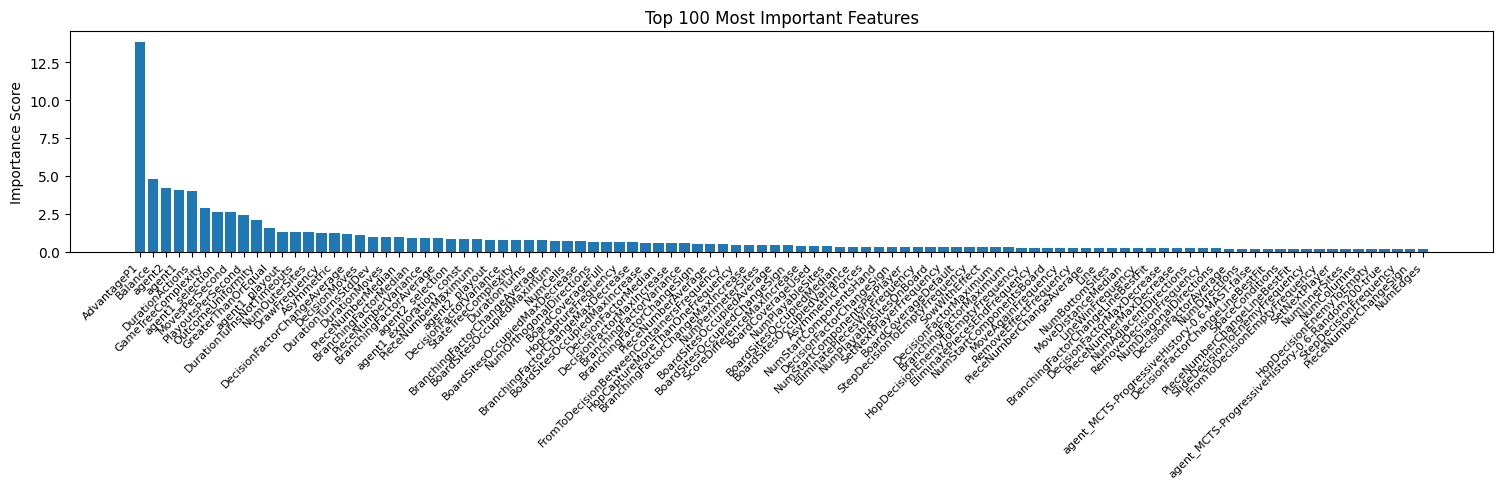

Fold 5 - RMSE: 0.42958220882383535
List of oof scores: [0.43332775375853033, 0.41437222765706977, 0.41988228198840993, 0.4151951983161339, 0.42958220882383535]
Average oof score: 0.4224719341087959


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4209
Score: 0.4382
Score: 0.4311
Score: 0.4429
Score: 0.4020
Average CV1 Score: 0.4270

CV2 OOF Scores:
Score: 0.4061
Score: 0.3951
Score: 0.4284
Score: 0.4339
Score: 0.4329
Average CV2 Score: 0.4193

CV3 OOF Scores:
Score: 0.4333
Score: 0.4144
Score: 0.4199
Score: 0.4152
Score: 0.4296
Average CV3 Score: 0.4225


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

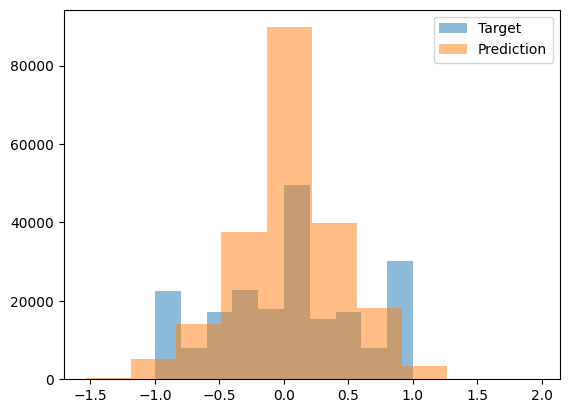

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.181029       │
│ 233235 ┆ -0.178902      │
│ 233236 ┆ 0.034501       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***